In [1]:
# %pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import pyarrow
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path_to_data_folder = r"C:\Users\ssriram1\Inside MD Anderson\Siewerdsen,Jeffrey Harold - data"
data = pd.read_parquet(rf"{path_to_data_folder}\procedure_data.parquet.gzip", engine='pyarrow')

## Dealing Procedure Panel Numbers

In [4]:
# Check for duplicate Procedure Panel numbers within each ID group
duplicated_procedure_panel = data.duplicated(subset=['ID', 'Procedure Panel'], keep=False)

# Filter data with duplicated Procedure Panel numbers
duplicated_data = data[duplicated_procedure_panel]

# Group by ID and Procedure Panel to check if there are multiple Panel Services with the same Procedure Panel number
grouped = duplicated_data.groupby(['ID', 'Procedure Panel'])['Panel Service'].nunique()

# Filter groups where there are multiple Panel Services with the same Procedure Panel number
multiple_services = grouped[grouped > 1].reset_index()

# Get the count of such IDs and the IDs themselves
ids_with_multiple_services = multiple_services['ID'].unique()
count_ids = len(ids_with_multiple_services)

# Display the results
print(f"Count of IDs with multiple services having the same procedure panel number: {count_ids}")
print(f"IDs with multiple services having the same procedure panel number: {ids_with_multiple_services}")


Count of IDs with multiple services having the same procedure panel number: 265
IDs with multiple services having the same procedure panel number: ['003d695474' '0107c27bd5' '011176fab0' '017985823b' '03a14259a1'
 '03d81a3452' '04e3c9f917' '04f543f4d7' '05af5254e3' '05dba794bb'
 '066bf37e8d' '07bf9e8439' '0ad195804b' '0dc0d4048e' '0e1681e83c'
 '0ea4dcea0d' '0ebdc5ac13' '1381ac5881' '1519f206aa' '15bdda68b5'
 '177303a797' '19a66a8559' '1c93326ca9' '1f74e9cc35' '1f82b5c671'
 '2021348c0a' '216d6b5674' '225dc03582' '2499797a83' '25091d462e'
 '25eeda4b5e' '26e1566cd4' '26ffcd85fb' '27b2827fd6' '2897b4e1c7'
 '2a74ef4712' '2e86f08b55' '30afe2175c' '30eefa2b61' '3239d74f3b'
 '32b42ed5cf' '32ceeb6379' '3338cad468' '3564f90bb6' '359e43a1a3'
 '360ddd1ec7' '3617b83315' '3638566b24' '3796363efb' '37e3806b67'
 '382e351333' '38da4cf1f7' '3ab63e1552' '3b31a6fa94' '3bad61145b'
 '3f128aa853' '3f280bf211' '41ca9401b0' '41dcd001c6' '43791b6319'
 '43d5d689bf' '43f8620a34' '44a71a0224' '46bea3e3da' '483b3b5

In [5]:
def find_inconsistent_ids(data):
    inconsistent_ids = set()
    
    # Case 1: Different `Procedure Panel` numbers for the same `Panel Service`
    for id, group in data.groupby('ID'):
        service_panel_counts = group.groupby('Panel Service')['Procedure Panel'].nunique()
        if (service_panel_counts > 1).any():
            inconsistent_ids.add(id)
    
    # Case 2: Same `Procedure Panel` numbers for different `Panel Service`
    for id, group in data.groupby('ID'):
        panel_service_counts = group.groupby('Procedure Panel')['Panel Service'].nunique()
        if (panel_service_counts > 1).any():
            inconsistent_ids.add(id)
    
    return list(inconsistent_ids)

inconsistent_ids = find_inconsistent_ids(data)

# Function to resolve inconsistencies
def resolve_inconsistencies(data, inconsistent_ids):
    for id in inconsistent_ids:
        id_data = data[data['ID'] == id].copy()  # Include all rows initially
        
        # Step 1: Fix different `Procedure Panel` numbers for the same `Panel Service`
        for panel_service in id_data['Panel Service'].unique():
            panel_numbers = id_data[id_data['Panel Service'] == panel_service]['Procedure Panel']
            if panel_numbers.nunique() > 1:
                print(f"ID: {id}, Panel Service: {panel_service}, Panel Numbers: {panel_numbers.tolist()}")  # Debug info
                try:
                    # Find the most frequent number
                    panel_counts = panel_numbers.value_counts()
                    most_frequent = panel_counts.idxmax()  # Get the most frequent number
                    print(f"Most Frequent Panel Number: {most_frequent}")  # Debug info
                    # Change the number for rows that are not initially numbered as 1
                    data.loc[(data['ID'] == id) & (data['Panel Service'] == panel_service) & (data['Procedure Panel'] != 1), 'Procedure Panel'] = most_frequent
                except Exception as e:
                    print(f"Error resolving panels for ID {id}, Panel Service {panel_service}: {e}, Panel Numbers: {panel_numbers.tolist()}")
        
        # Step 2: Fix same `Procedure Panel` numbers for different `Panel Service`
        id_data = data[data['ID'] == id].copy()  # Include all rows initially
        used_numbers = set(id_data['Procedure Panel'].unique())
        all_possible_numbers = set(range(1, max(6, len(id_data['Panel Service'].unique()) + 1)))
        available_numbers = list(all_possible_numbers - used_numbers)
        
        for panel_number in id_data['Procedure Panel'].unique():
            services_with_same_panel = id_data[id_data['Procedure Panel'] == panel_number]['Panel Service']
            if services_with_same_panel.nunique() > 1:
                for i, service in enumerate(services_with_same_panel.unique()):
                    if i == 0:
                        continue  # Keep the first service with the current panel number
                    if available_numbers:
                        new_number = available_numbers.pop(0)
                    else:
                        remaining_numbers = list(all_possible_numbers - used_numbers)
                        if not remaining_numbers:
                            new_number = max(used_numbers) + 1
                        else:
                            new_number = np.random.choice(remaining_numbers)
                    data.loc[(data['ID'] == id) & (data['Panel Service'] == service) & (data['Procedure Panel'] != 1), 'Procedure Panel'] = new_number
                    used_numbers.add(new_number)
    
    return data

# Resolve inconsistencies
data = resolve_inconsistencies(data, inconsistent_ids)


ID: cda1c1bfb0, Panel Service: SURG ONC - PANCREAS, Panel Numbers: [2, 1, 2, 1]
Most Frequent Panel Number: 2
ID: 3ab63e1552, Panel Service: THRCV - THORACIC SURGERY, Panel Numbers: [4, 3, 3]
Most Frequent Panel Number: 3
ID: 3ab63e1552, Panel Service: SURG ONC - ENDOCRINE, Panel Numbers: [3, 1]
Most Frequent Panel Number: 3
ID: 383e0f694f, Panel Service: UROLOGY, Panel Numbers: [2, 3, 2]
Most Frequent Panel Number: 2
ID: 2fb1e05beb, Panel Service: PLS - PLASTIC SURGERY, Panel Numbers: [1, 1, 2, 1]
Most Frequent Panel Number: 1
ID: 83269d29c4, Panel Service: HN - HEAD & NECK SURGERY, Panel Numbers: [1, 1, 1, 1, 1, 2, 1]
Most Frequent Panel Number: 1
ID: 9c1f122c13, Panel Service: UROLOGY, Panel Numbers: [1, 2]
Most Frequent Panel Number: 1
ID: 9c1f122c13, Panel Service: PLS - PLASTIC SURGERY, Panel Numbers: [4, 4, 4, 3]
Most Frequent Panel Number: 4
ID: 4dcffcfdcc, Panel Service: UROLOGY, Panel Numbers: [4, 3]
Most Frequent Panel Number: 4
ID: ee3b6777cf, Panel Service: THRCV - THORACI

In [6]:
# Function to update procedure panel numbers
def update_procedure_panels(data, id):
    id_data = data[data['ID'] == id]
    
    # Ensure Primary Service matching Panel Service is numbered as 1
    data.loc[(data['ID'] == id) & (data['Primary Service'] == data['Panel Service']), 'Procedure Panel'] = 1
    
    # Get updated data for the ID after numbering Primary Service matches
    id_data = data[data['ID'] == id]
    
    # Ensure all Panel Service entries are consistent with the updated numbering
    panel_mapping = {}
    for index, row in id_data.iterrows():
        panel_service = row['Panel Service']
        procedure_panel = row['Procedure Panel']
        if panel_service in panel_mapping:
            data.loc[(data['ID'] == id) & (data['Panel Service'] == panel_service), 'Procedure Panel'] = panel_mapping[panel_service]
        else:
            panel_mapping[panel_service] = procedure_panel
    
    return data

# Apply the function to all relevant IDs to make '1' consistent first
for id in ids_with_multiple_services:
    data = update_procedure_panels(data, id)


In [7]:
# List of IDs to extract Procedure Panel numbers for
id_list = [
    '017985823b', '1f82b5c671', '2021348c0a', '2e86f08b55', '359e43a1a3',
    '382e351333', '46bea3e3da', '495a0d8f6f', '4bcb78a729', '5044e026d3',
    '5683c32215', '63074c8262', '654cdd90ae', '66684dad65', '6ce0fd4700',
    '7864fb6325', '79afe849f5', '7b745c1d62', '8008c95743', '809d4ba50b',
    '829d0546a2', '88d20443a4', '88f7214c97', '9188434795', '91b6dc4c72',
    '9619a0ecc9', '97484cd4af', '9aa94b5d6d', '9ba11cb5cd', 'a040d3e8d0',
    'a0460289bb', 'a15261e745', 'a15b2cce8d', 'b08ddc1c17', 'b456c0f0bb',
    'bde27e1326', 'c19ce6ced9', 'c487d81519', 'd332d618bc', 'd507f0fad0',
    'dbbe273d51', 'dc01a1041e', 'ddda8f4c33', 'ef7e5ff63d', 'f644545258',
    'f650c2c0f3'
]

# Filter the data to get the rows with the specified IDs
filtered_data = data[data['ID'].isin(id_list)]

# Group by ID and list the Procedure Panel numbers
procedure_panel_numbers = filtered_data.groupby('ID')['Procedure Panel'].apply(list)

# Display the Procedure Panel numbers for the specified IDs
print(procedure_panel_numbers)

ID
017985823b                               [1, 1, 1]
1f82b5c671                [2, 2, 2, 2, 1, 1, 2, 1]
2021348c0a                               [1, 1, 1]
2e86f08b55                         [1, 1, 1, 1, 1]
359e43a1a3                [1, 3, 3, 3, 1, 1, 1, 1]
382e351333                               [1, 1, 1]
46bea3e3da                               [1, 1, 1]
495a0d8f6f                               [1, 1, 1]
4bcb78a729                               [1, 1, 1]
5044e026d3                            [1, 1, 1, 1]
5683c32215                            [1, 1, 1, 1]
63074c8262                            [1, 1, 1, 1]
654cdd90ae                [1, 1, 1, 1, 1, 1, 1, 1]
66684dad65                         [1, 1, 1, 1, 1]
6ce0fd4700                                  [1, 1]
7864fb6325                               [1, 1, 1]
79afe849f5                            [1, 1, 1, 1]
7b745c1d62                               [1, 1, 1]
8008c95743                            [1, 1, 1, 1]
809d4ba50b                  

In [8]:
# Find the rows where Procedure Panel is 1 and Primary Service is not equal to Panel Service
to_renumber = data[(data['Procedure Panel'] == 1) & (data['Primary Service'] != data['Panel Service'])]

# Function to renumber the panel service
def renumber_panel_service(data):
    for idx, row in to_renumber.iterrows():
        id_group = data[data['ID'] == row['ID']]
        used_numbers = set(id_group['Procedure Panel'].unique())
        all_possible_numbers = set(range(1, len(id_group) + 1))
        available_numbers = list(all_possible_numbers - used_numbers)
        
        if available_numbers:
            new_number = available_numbers[0]
        else:
            new_number = max(used_numbers) + 1
        
        data.at[idx, 'Procedure Panel'] = new_number
    return data

# Apply the function
data = renumber_panel_service(data)

In [9]:
# Function to update procedure panel numbers
def update_procedure_panels(data, id):
    id_data = data[data['ID'] == id]
    
    # Ensure Primary Service matching Panel Service is numbered as 1
    data.loc[(data['ID'] == id) & (data['Primary Service'] == data['Panel Service']), 'Procedure Panel'] = 1
    
    # Get updated data for the ID after numbering Primary Service matches
    id_data = data[data['ID'] == id]
    
    # Ensure all Panel Service entries are consistent with the updated numbering
    panel_mapping = {}
    for index, row in id_data.iterrows():
        panel_service = row['Panel Service']
        procedure_panel = row['Procedure Panel']
        if panel_service in panel_mapping:
            data.loc[(data['ID'] == id) & (data['Panel Service'] == panel_service), 'Procedure Panel'] = panel_mapping[panel_service]
        else:
            panel_mapping[panel_service] = procedure_panel
    
    return data

# Apply the function to all relevant IDs to make '1' consistent first
for id in ids_with_multiple_services:
    data = update_procedure_panels(data, id)

In [10]:
# Check for duplicate Procedure Panel numbers within each ID group
duplicated_procedure_panel = data.duplicated(subset=['ID', 'Procedure Panel'], keep=False)

# Filter data with duplicated Procedure Panel numbers
duplicated_data = data[duplicated_procedure_panel]

# Group by ID and Procedure Panel to check if there are multiple Panel Services with the same Procedure Panel number
grouped = duplicated_data.groupby(['ID', 'Procedure Panel'])['Panel Service'].nunique()

# Filter groups where there are multiple Panel Services with the same Procedure Panel number
multiple_services = grouped[grouped > 1].reset_index()

# Get the count of such IDs and the IDs themselves
ids_with_multiple_services = multiple_services['ID'].unique()
count_ids = len(ids_with_multiple_services)

# Display the results
print(f"Count of IDs with multiple services having the same procedure panel number: {count_ids}")
print(f"IDs with multiple services having the same procedure panel number: {ids_with_multiple_services}")

Count of IDs with multiple services having the same procedure panel number: 7
IDs with multiple services having the same procedure panel number: ['2164da831b' '35a44678e9' '3c3bfe3c17' 'cdec49f6e0' 'df478ede0e'
 'e435feb8d8' 'e95a17924d']


In [11]:
# Function to update procedure panel numbers
def update_procedure_panels(data, id):
    id_data = data[data['ID'] == id]
    
    # Ensure Primary Service matching Panel Service is numbered as 1
    data.loc[(data['ID'] == id) & (data['Primary Service'] == data['Panel Service']), 'Procedure Panel'] = 1
    
    # Get updated data for the ID after numbering Primary Service matches
    id_data = data[data['ID'] == id]
    
    # Ensure all Panel Service entries are consistent with the updated numbering
    panel_mapping = {}
    for index, row in id_data.iterrows():
        panel_service = row['Panel Service']
        procedure_panel = row['Procedure Panel']
        if panel_service in panel_mapping:
            data.loc[(data['ID'] == id) & (data['Panel Service'] == panel_service), 'Procedure Panel'] = panel_mapping[panel_service]
        else:
            panel_mapping[panel_service] = procedure_panel
    
    return data

# Apply the function to all relevant IDs to make '1' consistent first
for id in ids_with_multiple_services:
    data = update_procedure_panels(data, id)

In [12]:
# Check for duplicate Procedure Panel numbers within each ID group
duplicated_procedure_panel = data.duplicated(subset=['ID', 'Procedure Panel'], keep=False)

# Filter data with duplicated Procedure Panel numbers
duplicated_data = data[duplicated_procedure_panel]

# Group by ID and Procedure Panel to check if there are multiple Panel Services with the same Procedure Panel number
grouped = duplicated_data.groupby(['ID', 'Procedure Panel'])['Panel Service'].nunique()

# Filter groups where there are multiple Panel Services with the same Procedure Panel number
multiple_services = grouped[grouped > 1].reset_index()

# Get the count of such IDs and the IDs themselves
ids_with_multiple_services = multiple_services['ID'].unique()
count_ids = len(ids_with_multiple_services)

# Display the results
print(f"Count of IDs with multiple services having the same procedure panel number: {count_ids}")
print(f"IDs with multiple services having the same procedure panel number: {ids_with_multiple_services}")

Count of IDs with multiple services having the same procedure panel number: 0
IDs with multiple services having the same procedure panel number: []


In [13]:
data_1=data.copy()

## Handling Outliers in Numerical Features

## BMI

In [14]:
bmi_min = data_1['BMI'].min()
bmi_max = data_1['BMI'].max()

print(f"Range of BMI values: {bmi_min} - {bmi_max}")

Range of BMI values: 10.07 - 28369.7


In [15]:
# Function to detect outliers using the IQR method
def find_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2.5 * IQR
    upper_bound = Q3 + 2.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers

In [16]:
bmi_outliers = find_outliers_iqr(data_1['BMI'])

# Display the number of outliers
num_bmi_outliers = len(bmi_outliers)
print(f"Number of outliers in BMI column: {num_bmi_outliers}")

Number of outliers in BMI column: 611


In [17]:
data_1 = data_1[~data_1['BMI'].isin(bmi_outliers)]

In [18]:
# Convert weight from lb to kg
data_1['Weight (kg)'] = data_1['Weight (kg)'] * 0.453592

In [19]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 139023 entries, 660 to 24898
Data columns (total 44 columns):
 #   Column                                 Non-Null Count   Dtype   
---  ------                                 --------------   -----   
 0   ID                                     139023 non-null  object  
 1   Age at Surgery                         139023 non-null  Int64   
 2   Height (cm)                            138079 non-null  float64 
 3   Weight (kg)                            103585 non-null  float64 
 4   BMI                                    122509 non-null  float64 
 5   Sex                                    139023 non-null  object  
 6   Ethnicity                              139023 non-null  object  
 7   Primary Race                           139019 non-null  object  
 8   Surgery Diagnosis Name                 139019 non-null  object  
 9   Surgery Diagnosis Code                 138559 non-null  object  
 10  Location                               139023 no

In [20]:
# Pull out rows where either BMI, Height (cm), or Weight (kg) is missing
subset_data = data_1[data_1['BMI'].isnull() | data_1['Height (cm)'].isnull() | data_1['Weight (kg)'].isnull()]

# Keep the rows with no missing values in BMI, Height (cm), and Weight (kg) for median calculation
complete_data = data_1.dropna(subset=['BMI', 'Height (cm)', 'Weight (kg)'])

# Calculate median BMI based on age and sex in 10-year age buckets
# Create age buckets
complete_data['Age_Bucket'] = pd.cut(complete_data['Age at Surgery'], bins=range(0, 101, 10), right=False)

# Calculate median BMI for each age bucket and sex
median_bmi = complete_data.groupby(['Age_Bucket', 'Sex'])['BMI'].median().reset_index()

# Function to assign median BMI to missing values
def fill_missing_bmi(row, median_bmi):
    if pd.isnull(row['BMI']):
        age_bucket = pd.cut([row['Age at Surgery']], bins=range(0, 101, 10), right=False)[0]
        median_value = median_bmi[(median_bmi['Age_Bucket'] == age_bucket) & (median_bmi['Sex'] == row['Sex'])]['BMI']
        if not median_value.empty:
            return median_value.values[0]
    return row['BMI']

# Step 3: Fill missing BMI values in subset data with calculated median values
subset_data['BMI'] = subset_data.apply(fill_missing_bmi, axis=1, median_bmi=median_bmi)

# Step 4: Merge subset data with complete data to create final dataframe data_2
data_2 = pd.concat([complete_data, subset_data], ignore_index=True)

# Drop the Age_Bucket column used for calculations if needed
data_2 = data_2.drop(columns=['Age_Bucket'], errors='ignore')


C:\Users\ssriram1\AppData\Local\Temp\ipykernel_21052\3068977919.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_data['Age_Bucket'] = pd.cut(complete_data['Age at Surgery'], bins=range(0, 101, 10), right=False)
C:\Users\ssriram1\AppData\Local\Temp\ipykernel_21052\3068977919.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_bmi = complete_data.groupby(['Age_Bucket', 'Sex'])['BMI'].median().reset_index()
C:\Users\ssriram1\AppData\Local\Temp\ipykernel_21052\3068977919.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [21]:
bmi_min = data_2['BMI'].min()
bmi_max = data_2['BMI'].max()

print(f"Range of BMI values: {bmi_min} - {bmi_max}")

Range of BMI values: 10.07 - 52.77


## Drop Height (cm) and Weight(kg)

In [22]:
data_2 = data_2.drop(columns = ['Height (cm)', 'Weight (kg)'])

In [23]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139023 entries, 0 to 139022
Data columns (total 42 columns):
 #   Column                                 Non-Null Count   Dtype   
---  ------                                 --------------   -----   
 0   ID                                     139023 non-null  object  
 1   Age at Surgery                         139023 non-null  Int64   
 2   BMI                                    139023 non-null  float64 
 3   Sex                                    139023 non-null  object  
 4   Ethnicity                              139023 non-null  object  
 5   Primary Race                           139019 non-null  object  
 6   Surgery Diagnosis Name                 139019 non-null  object  
 7   Surgery Diagnosis Code                 138559 non-null  object  
 8   Location                               139023 non-null  object  
 9   Primary Service                        139023 non-null  object  
 10  Primary Service (Rolled Up)            13902

## Summating Scheduled Panel Lengths and Panel Default Lengths

In [24]:
columns_to_sum = ['Scheduled Panel 1 Length', 'Scheduled Panel 2 Length', 'Scheduled Panel 3 Length', 'Scheduled Panel 4 Length', 'Scheduled Panel 5 Length']
data_2['Total Scheduled Panel Length'] = data_2[columns_to_sum].sum(axis=1)
data_2.drop(columns=columns_to_sum, inplace=True)

columns_to_sum = ['Panel 1 Default Length', 'Panel 2 Default Length', 'Panel 3 Default Length', 'Panel 4 Default Length', 'Panel 5 Default Length']
data_2['Total Panel Default Length'] = data_2[columns_to_sum].sum(axis=1)
data_2.drop(columns=columns_to_sum, inplace=True)

In [25]:
spl_outliers = find_outliers_iqr(data_2['Total Scheduled Panel Length'])

# Display the number of outliers
num_spl_outliers = len(spl_outliers)
print(f"Number of outliers in Total Scheduled Panel Length column: {num_spl_outliers}")

Number of outliers in Total Scheduled Panel Length column: 420


In [26]:
data_2 = data_2[~data_2['Total Scheduled Panel Length'].isin(spl_outliers)]

In [27]:
pdl_outliers = find_outliers_iqr(data_2['Total Panel Default Length'])

# Display the number of outliers
num_pdl_outliers = len(pdl_outliers)
print(f"Number of outliers in Total Panel Default Length column: {num_pdl_outliers}")

Number of outliers in Total Panel Default Length column: 4300


In [28]:
data_2 = data_2[~data_2['Total Panel Default Length'].isin(pdl_outliers)]

In [29]:
nan_count = data_2['Total Panel Default Length'].isnull().sum()

# Display the count of NaN values
print(f"Number of NaN values in 'Total Scheduled Panel Length': {nan_count}")

Number of NaN values in 'Total Scheduled Panel Length': 0


In [30]:
min = data_2['Total Scheduled Panel Length'].min()
max = data_2['Total Scheduled Panel Length'].max()

print(f"Range of values: {min} - {max}")

Range of values: 1.0 - 945.0


## Filling NaN in In Recovery to Discharge Time Minutes

In [31]:
data_2['In Recovery to Discharge Time Minutes'] = data_2['In Recovery to Discharge Time Minutes'].abs()

In [32]:
rdt_outliers = find_outliers_iqr(data_2['In Recovery to Discharge Time Minutes'])

# Display the number of outliers
num_rdt_outliers = len(rdt_outliers)
print(f"Number of outliers in In Recovery to Discharge Time Minutes column: {num_rdt_outliers}")

Number of outliers in In Recovery to Discharge Time Minutes column: 5026


In [33]:
data_2 = data_2[~data_2['In Recovery to Discharge Time Minutes'].isin(rdt_outliers)]

In [34]:
nan_count = data_2['In Recovery to Discharge Time Minutes'].isnull().sum()

# Display the count of NaN values
print(f"Number of NaN values in 'In Recovery to Discharge Time Minutes': {nan_count}")

Number of NaN values in 'In Recovery to Discharge Time Minutes': 5330


In [35]:
column_name = 'In Recovery to Discharge Time Minutes'

rows_with_nan_in_recovery_to_discharge_time_minutes = data_2[data_2[column_name].isna()]
# print(rows_with_nan_in_recovery_to_discharge_time_minutes.shape)
unique_panel_in_recovery_to_discharge_time_minutes = rows_with_nan_in_recovery_to_discharge_time_minutes['Panel Service'].unique().tolist()
# print("Unique Panel Service with NaN In Recovery to Discharge Time Minutes :", unique_panel_in_recovery_to_discharge_time_minutes)

for i in unique_panel_in_recovery_to_discharge_time_minutes:
    subset_data_1 = data_2[data_2['Panel Service'] == i]
    median_in_recovery_to_discharge_time_minutes = subset_data_1['In Recovery to Discharge Time Minutes'].median()
    if pd.isna(median_in_recovery_to_discharge_time_minutes):
        j = subset_data_1['Anesthesia Type'].iloc[0]
        subset_data_2 = data_2[data_2['Anesthesia Type'] == j]
        median_in_recovery_to_discharge_time_minutes = subset_data_2['In Recovery to Discharge Time Minutes'].median()
    # print(f"Median In Recovery to Discharge Time Minutes for Primary Procedure Name '{i}': {median_in_recovery_to_discharge_time_minutes}")
    data_2.loc[(data_2['Panel Service'] == i) & (data_2['In Recovery to Discharge Time Minutes'].isna()), 'In Recovery to Discharge Time Minutes'] = median_in_recovery_to_discharge_time_minutes

c:\Users\ssriram1\Documents\Code\mda_env\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [36]:
min = data_2['In Recovery to Discharge Time Minutes'].min()
max = data_2['In Recovery to Discharge Time Minutes'].max()

print(f"Range of values: {min} - {max}")

Range of values: 0.0 - 16614.0


In [37]:
data_2.loc[:,'Hours in recovery to discharge'] = data_2.loc[:,'In Recovery to Discharge Time Minutes']/60.0

## LOS Groups

In [38]:
LOS_categories = data_2['LOS 4 groups'].cat.categories

def categorize_missing_rows(row):
    if pd.isna(row['LOS 4 groups']):
        value = row['Hours in recovery to discharge']
        if value < 12:
            return LOS_categories[0]
        elif 12 <= value < 36:
            return LOS_categories[1]
        elif 36 <= value < 60:
            return LOS_categories[2]
        else:
            return LOS_categories[3]
    else:
        return row['LOS 4 groups']

data_2['LOS 4 groups'] = data_2.apply(categorize_missing_rows, axis=1)

## In Recovery to Discharge Time Minutes & Hours in recovery to discharge- Drop Column

In [39]:
data_2 = data_2.drop(columns=['In Recovery to Discharge Time Minutes'])
data_2 = data_2.drop(columns=['Hours in recovery to discharge'])

## Filling NaN in Intraop Minutes

In [40]:
im_outliers = find_outliers_iqr(data_2['Intraop Minutes'])

# Display the number of outliers
num_im_outliers = len(im_outliers)
print(f"Number of outliers in In Intraop Minutes column: {num_im_outliers}")

Number of outliers in In Intraop Minutes column: 812


In [41]:
data_2 = data_2[~data_2['Intraop Minutes'].isin(im_outliers)]

In [42]:
nan_count = data_2['Intraop Minutes'].isnull().sum()

# Display the count of NaN values
print(f"Number of NaN values in 'Intraop Minutess': {nan_count}")

Number of NaN values in 'Intraop Minutess': 1863


In [43]:
column_name = 'Intraop Minutes'
rows_with_nan_intraop_minutes = data_2[data_2[column_name].isna()]
# print(rows_with_nan_intraop_minutes.shape)
unique_panel_intraop_minutes = rows_with_nan_intraop_minutes['Panel Service'].unique().tolist()
# print("Unique Panel Service with NaN in Intraop Minutes:", unique_panel_intraop_minutes)

for i in unique_panel_intraop_minutes:
    subset_data_1 = data_2[data_2['Panel Service'] == i]
    median_intraop_minutes = subset_data_1['Intraop Minutes'].median()
    # print(f"Median Intraop Minutes for Panel Service '{i}': {median_intraop_minutes}")
    data_2.loc[(data_2['Panel Service'] == i) & (data_2['Intraop Minutes'].isna()), 'Intraop Minutes'] = median_intraop_minutes

In [44]:
min = data_2['Intraop Minutes'].min()
max = data_2['Intraop Minutes'].max()

print(f"Range of values: {min} - {max}")

Range of values: 13.0 - 886.0


## Filling NaN in Scheduled Room Duration

In [45]:
srd_outliers = find_outliers_iqr(data_2['Scheduled Room Duration'])

# Display the number of outliers
num_srd_outliers = len(srd_outliers)
print(f"Number of outliers in Scheduled Room Duration column: {num_srd_outliers}")

Number of outliers in Scheduled Room Duration column: 1352


In [46]:
data_2 = data_2[~data_2['Scheduled Room Duration'].isin(im_outliers)]

In [47]:
nan_count = data_2['Scheduled Room Duration'].isnull().sum()

# Display the count of NaN values
print(f"Number of NaN values in 'Scheduled Room Duration': {nan_count}")

Number of NaN values in 'Scheduled Room Duration': 1610


In [48]:
column_name = 'Scheduled Room Duration'
rows_with_nan_scheduled_room_duration = data_2[data_2[column_name].isna()]
# print(rows_with_nan_scheduled_room_duration.shape)
unique_primary_scheduled_room_duration = rows_with_nan_scheduled_room_duration['Primary Service'].unique().tolist()
# print("Unique Primary Service with NaN in Scheduled Room Duration:", unique_primary_scheduled_room_duration)

for i in unique_primary_scheduled_room_duration:
    subset_data_1 = data_2[data_2['Primary Service'] == i]
    median_scheduled_room_duration = subset_data_1['Scheduled Room Duration'].median()
    print(f"Median Scheduled Room Duration for Primary Service '{i}': {median_scheduled_room_duration}")
    data_2.loc[(data_2['Primary Service'] == i) & (data_2['Scheduled Room Duration'].isna()), 'Scheduled Room Duration'] = median_scheduled_room_duration

Median Scheduled Room Duration for Primary Service 'GYN - GYNECOLOGIC ONCOLOGY': 160.0
Median Scheduled Room Duration for Primary Service 'BREAST': 190.0
Median Scheduled Room Duration for Primary Service 'NEUROSURGERY': 305.0
Median Scheduled Room Duration for Primary Service 'HN - HEAD & NECK SURGERY': 185.0
Median Scheduled Room Duration for Primary Service 'COLON & RECTAL SURGERY': 330.0
Median Scheduled Room Duration for Primary Service 'PLS - PLASTIC SURGERY': 140.0
Median Scheduled Room Duration for Primary Service 'RADIATION ONCOLOGY': 85.0
Median Scheduled Room Duration for Primary Service 'GYN - GENERAL GYNECOLOGY': 25.0
Median Scheduled Room Duration for Primary Service 'ORTHOPEDIC ONCOLOGY': 180.0
Median Scheduled Room Duration for Primary Service 'THRCV - THORACIC SURGERY': 180.0
Median Scheduled Room Duration for Primary Service 'OPHTHALMOLOGY': 40.0
Median Scheduled Room Duration for Primary Service 'SURG ONC - GASTRIC/HIPEC': 280.0
Median Scheduled Room Duration for Pri

In [49]:
min = data_2['Scheduled Room Duration'].min()
max = data_2['Scheduled Room Duration'].max()

print(f"Range of values: {min} - {max}")

Range of values: 1.0 - 940.0


## Categorical Features

## Sex

In [50]:
count_sex = data_2[data_2['Sex'].isna()]
print(count_sex.shape)

count_sex = data_2['Sex'].value_counts()
count_sex = count_sex.to_dict()
print("Sex", count_sex)

(0, 32)
Sex {'Female': 79646, 'Male': 48739}


## Ethinicity and Primary Race

In [51]:
count_ethnicity = data_2['Ethnicity'].value_counts()
count_ethnicity = count_ethnicity.to_dict()
print("Ethnicity", count_ethnicity)

rename_ethnicity_mapping = {
    'Declined to Answer': 'Unknown',
    'Unknown Ethnicity': 'Unknown',
}

data_2['Ethnicity'] = data_2['Ethnicity'].replace(rename_ethnicity_mapping)

count_ethnicity = data_2['Ethnicity'].value_counts()
count_ethnicity = count_ethnicity.to_dict()
print("Ethnicity", count_ethnicity)

Ethnicity {'Not Hispanic or Latino': 105550, 'Hispanic or Latino': 19720, 'Declined to Answer': 2910, 'Unknown': 195, 'Unknown Ethnicity': 10}
Ethnicity {'Not Hispanic or Latino': 105550, 'Hispanic or Latino': 19720, 'Unknown': 3115}


In [52]:
count_primary_race = data_2['Primary Race'].value_counts()
count_primary_race = count_primary_race.to_dict()
print("Primary Race", count_primary_race)

column_name = 'Primary Race'
fill_value = 'Other'
data_2.loc[:, column_name] = data_2.loc[:, column_name].fillna(fill_value)

rename_ethnicity_mapping = {
    'Declined to Answer': 'Other',
    'Unknown': 'Other',
}

data_2['Primary Race'] = data_2['Primary Race'].replace(rename_ethnicity_mapping)

count_primary_race = data_2['Primary Race'].value_counts()
count_primary_race = count_primary_race.to_dict()
print("Primary Race", count_primary_race)

Primary Race {'White or Caucasian': 98865, 'Black or African American': 11372, 'Other': 8600, 'Asian': 7288, 'Declined to Answer': 1129, 'American Indian or Alaska Native': 759, 'Native Hawaiian or Other Pacific Islander': 241, 'Unknown': 127}
Primary Race {'White or Caucasian': 98865, 'Black or African American': 11372, 'Other': 9860, 'Asian': 7288, 'American Indian or Alaska Native': 759, 'Native Hawaiian or Other Pacific Islander': 241}


## Patient Class, Anesthesia Type, and ASA Status

In [53]:
count_patient_class = data_2['Patient Class'].value_counts()
count_patient_class = count_patient_class.to_dict()
print("Patient Class", count_patient_class)

column_name = 'Patient Class'
rows_with_nan_patient_class = data_2[data_2[column_name].isna()]
rows_with_nan_patient_class['Surgery Diagnosis Name'].unique()

Patient Class {'Hospital Outpatient Surgery': 72819, 'Surgery Admit': 48595, 'Inpatient': 6221, 'Emergency': 750}


array([], dtype=object)

In [54]:
count_anesthesia_type = data_2['Anesthesia Type'].value_counts()
count_anesthesia_type = count_anesthesia_type.to_dict()
print("Anesthesia Type", count_anesthesia_type)

column_name = 'Anesthesia Type'
rows_with_nan_anesthesia_type = data_2[data_2[column_name].isna()]
unqiue_primary_service = rows_with_nan_anesthesia_type['Primary Service'].unique()

data_2.loc[:, column_name] = data_2.loc[:, column_name].fillna('General')

Anesthesia Type {'General': 113426, 'Monitor Anesthesia Care': 7058, 'Regional': 5906, 'Epidural': 1859, 'Local': 81, 'TIVA': 37, 'Moderate Sedation': 8, 'No Sedation': 2, 'Spinal': 1}


In [55]:
count_asa_status = data_2['ASA Status'].value_counts()
count_asa_status = count_asa_status.to_dict()
print("ASA Status", count_asa_status)

column_name = 'ASA Status'
rows_with_nan_asa_status = data_2[data_2[column_name].isna()]
rows_with_nan_asa_status['Surgery Diagnosis Name'].value_counts()

data_2.loc[:, column_name] = data_2.loc[:, column_name].fillna('Severe Sytemic Disease')

ASA Status {'Severe Systemic Disease': 104904, 'Mild Systemic Disease': 13520, 'Incapacitating Disease': 3257, 'Healthy': 320, 'Moribund': 48}


## Robotic Case

In [56]:
count_robotic_case = data_2['Robotic Case?'].value_counts()
count_robotic_case = count_robotic_case.to_dict()
print("Robotic Case", count_robotic_case)

rows_with_nan_robotic_case = data_2[data_2['Robotic Case?'].isna()]
rows_with_nan_robotic_case

Robotic Case {'N': 116237, 'Y': 12148}


,ID,Age at Surgery,BMI,Sex,Ethnicity,Primary Race,Surgery Diagnosis Name,Surgery Diagnosis Code,Location,Primary Service,...,Performed?,Procedure Panel,Panel Service,Panel Service (Rolled Up),Panel Primary Surgeon ID,Scheduled Room Duration,Intraop Minutes,LOS 4 groups,Total Scheduled Panel Length,Total Panel Default Length


## Scheduled? and Performed?

In [57]:
count_scheduled = data_2['Scheduled?'].value_counts()
count_scheduled = count_scheduled.to_dict()
print("Scheduled", count_scheduled)

rows_with_nan_scheduled = data_2[data_2['Scheduled?'].isna()]
rows_with_nan_scheduled


Scheduled {'Y': 108324, 'N': 20061}


,ID,Age at Surgery,BMI,Sex,Ethnicity,Primary Race,Surgery Diagnosis Name,Surgery Diagnosis Code,Location,Primary Service,...,Performed?,Procedure Panel,Panel Service,Panel Service (Rolled Up),Panel Primary Surgeon ID,Scheduled Room Duration,Intraop Minutes,LOS 4 groups,Total Scheduled Panel Length,Total Panel Default Length


In [58]:
count_performed = data_2['Performed?'].value_counts()
count_performed = count_performed.to_dict()
print("Performed", count_performed)

rows_with_nan_performed = data_2[data_2['Performed?'].isna()]
rows_with_nan_performed

Performed {'Y': 108695, 'N': 19690}


,ID,Age at Surgery,BMI,Sex,Ethnicity,Primary Race,Surgery Diagnosis Name,Surgery Diagnosis Code,Location,Primary Service,...,Performed?,Procedure Panel,Panel Service,Panel Service (Rolled Up),Panel Primary Surgeon ID,Scheduled Room Duration,Intraop Minutes,LOS 4 groups,Total Scheduled Panel Length,Total Panel Default Length


## Location

In [59]:

count_location  = data_2[data_2['Location'].isna()]
count_location.shape

count_location = data_2['Location'].value_counts()
count_location = count_location.to_dict()
print("Location", count_location)


Location {'MAIN OR': 94116, 'MAYS OR': 34269}


## Textual Features

## Surgery Diagnosis Name

In [60]:
column_name = 'Surgery Diagnosis Name'
rows_with_nan_surgery_diagnosis_name = data_2[data_2[column_name].isna()]
rows_with_nan_surgery_diagnosis_name

,ID,Age at Surgery,BMI,Sex,Ethnicity,Primary Race,Surgery Diagnosis Name,Surgery Diagnosis Code,Location,Primary Service,...,Performed?,Procedure Panel,Panel Service,Panel Service (Rolled Up),Panel Primary Surgeon ID,Scheduled Room Duration,Intraop Minutes,LOS 4 groups,Total Scheduled Panel Length,Total Panel Default Length
6719,375ef219d2,70,28.4,Female,Not Hispanic or Latino,Native Hawaiian or Other Pacific Islander,None,None,MAIN OR,COLON & RECTAL SURGERY,...,Y,1,COLON & RECTAL SURGERY,COLON & RECTAL SURGERY,101442,75.0,125.0,"[36, 60) hours",75.0,130.0
6720,375ef219d2,70,28.4,Female,Not Hispanic or Latino,Native Hawaiian or Other Pacific Islander,None,None,MAIN OR,COLON & RECTAL SURGERY,...,Y,1,COLON & RECTAL SURGERY,COLON & RECTAL SURGERY,101442,75.0,125.0,"[36, 60) hours",75.0,130.0
6726,375ef219d2,70,28.4,Female,Not Hispanic or Latino,Native Hawaiian or Other Pacific Islander,None,None,MAIN OR,COLON & RECTAL SURGERY,...,Y,1,COLON & RECTAL SURGERY,COLON & RECTAL SURGERY,101442,75.0,125.0,"[36, 60) hours",75.0,130.0
6732,375ef219d2,70,28.4,Female,Not Hispanic or Latino,Native Hawaiian or Other Pacific Islander,None,None,MAIN OR,COLON & RECTAL SURGERY,...,Y,1,COLON & RECTAL SURGERY,COLON & RECTAL SURGERY,101442,75.0,125.0,"[36, 60) hours",75.0,130.0


In [61]:
subset_data = data_2[data_2['Panel Primary Surgeon ID'] == 101442]
subset_data.head()
count_surgery_diag_name = subset_data['Surgery Diagnosis Name'].value_counts()
count_surgery_diag_name = count_surgery_diag_name.to_dict()
print("Surgery Diagnosis Name", count_surgery_diag_name)
print("Surgery Diagnosis Name Unique", len(count_surgery_diag_name.keys()))

data_2.loc[:, 'Surgery Diagnosis Name'] = data_2.loc[:, 'Surgery Diagnosis Name'].fillna('Rectal cancer')
data_2.loc[:, 'Surgery Diagnosis Name'] = data_2.loc[:, 'Surgery Diagnosis Name'].str.lower()

Surgery Diagnosis Name {'Rectal cancer': 231, 'Adenocarcinoma of rectum': 33, 'Adenocarcinoma, NOS of sigmoid colon': 25, 'Adenocarcinoma of sigmoid colon': 23, 'Adenocarcinoma, NOS of rectosigmoid junction': 20, 'Small bowel obstruction': 16, 'Adenocarcinoma, NOS of descending colon': 15, 'Familial multiple polyposis syndrome': 12, 'Abdominal pain': 11, 'Adenocarcinoma of rectosigmoid junction': 11, 'Adenocarcinoma, NOS of splenic flexure of colon': 10, 'Adenocarcinoma, NOS of ascending colon': 8, 'Adenocarcinoma, NOS of rectum, NOS': 8, 'Adenocarcinoma, NOS of hepatic flexure of colon': 7, 'Secondary malignant neoplasm of liver': 7, 'Adenocarcinoma, NOS of transverse colon': 7, 'Malignant neoplasm of cecum': 6, 'Chordoma of sacrum': 6, 'Primary leiomyosarcoma of retroperitoneum': 6, 'Tubulovillous adenoma, NOS of rectum, NOS': 6, 'Perineal wound dehiscence <Initial>': 6, 'Large intestine anastomotic leak <Initial>': 5, 'Adenocarcinoma in adenomatous polyp of descending colon': 5, 'Ma

In [62]:
count_surgery_diag_name = data_2['Surgery Diagnosis Name'].value_counts()
count_surgery_diag_name = count_surgery_diag_name.to_dict()
print("Surgery Diagnosis Name", count_surgery_diag_name)
print("Total Number of Keys", len(count_surgery_diag_name.keys()))

Surgery Diagnosis Name {'adenocarcinoma of prostate': 2314, 'infiltrating duct carcinoma, nos of overlapping lesion of breast <female; right>': 2310, 'rectal cancer': 2236, 'infiltrating duct carcinoma, nos of overlapping lesion of breast <female; left>': 2016, 'acquired absence of bilateral breasts and nipples': 1694, 'infiltrating duct carcinoma of right female breast': 1692, 'papillary thyroid carcinoma': 1662, 'infiltrating ductal carcinoma of upper outer quadrant of left female breast': 1434, 'secondary malignant neoplasm of liver': 1408, 'bladder cancer': 1347, 'adenocarcinoma, nos of prostate gland': 1269, 'infiltrating duct carcinoma, nos of upper-outer quadrant of breast <female; right>': 1268, 'infiltrating duct carcinoma, nos of upper-outer quadrant of breast <female; left>': 1255, 'infiltrating ductal carcinoma of upper outer quadrant of right female breast': 1209, 'malignant neoplasm of endometrium': 1154, 'infiltrating duct carcinoma, nos of breast, nos <female; left>': 1

## Surgery Diagnosis Code - Drop this Column

In [63]:
count_surgery_diag_code  = data_2[data_2['Surgery Diagnosis Code'].isna()]
count_surgery_diag_code.shape

(403, 32)

In [64]:
count_surgery_diag_code = data_2['Surgery Diagnosis Code'].value_counts()
count_surgery_diag_code = count_surgery_diag_code.to_dict()
print("Surgery Diagnosis Code", count_surgery_diag_code)
print("Total Number of Keys", len(count_surgery_diag_code.keys()))

Surgery Diagnosis Code {'C61': 4265, 'C50.911': 3292, 'C50.412': 3229, 'C50.411': 3205, 'C50.811': 3147, 'C50.812': 3009, 'C20': 2982, 'C50.912': 2932, 'C73': 2635, 'C67.9': 2110, 'Z90.13': 1963, 'C78.7': 1782, 'C54.1': 1718, 'D05.12': 1713, 'C49.9': 1658, 'D05.11': 1596, 'C18.7': 1273, 'C50.212': 1122, 'C02.9': 1108, 'Z90.12': 1085, 'C50.211': 1032, 'N28.89': 994, 'Z90.11': 988, 'C43.59': 976, 'C50.919': 948, 'C16.9': 904, 'C80.1': 901, 'N32.89': 891, 'C79.51': 883, 'C25.9': 876, 'C67.8': 874, 'C18.1': 856, 'C77.3': 809, 'C43.4': 755, 'Z15.01': 732, 'C15.5': 708, 'C50.512': 705, 'C03.9': 688, 'G93.9': 643, 'C50.511': 600, 'C43.9': 591, 'C50.312': 576, 'R97.20': 573, 'M95.2': 568, 'C43.62': 558, 'C18.2': 549, 'C56.9': 535, 'C10.9': 518, 'K13.79': 513, 'C53.9': 502, 'C71.9': 489, 'C43.61': 488, 'C49.4': 472, 'R19.09': 457, 'C34.11': 457, 'C50.311': 455, 'C41.9': 441, 'C50.111': 439, 'C50.112': 426, 'C69.20': 424, 'C43.72': 422, 'E21.0': 416, 'C78.6': 407, 'Z17.0': 406, 'R19.03': 398, 'N

In [65]:
data_2 = data_2.drop(columns=['Surgery Diagnosis Code'])

## Primary Service

In [66]:
data_2.loc[:, 'Primary Service'] = data_2.loc[:, 'Primary Service'].str.lower()

count_primary_service = data_2[data_2['Primary Service'].isna()]
print(count_primary_service.shape)

count_primary_service = data_2['Primary Service'].value_counts()
count_primary_service = count_primary_service.to_dict()
print("Primary Service", count_primary_service)
print("Primary Service Unique", len(count_primary_service.keys()))

(0, 31)
Primary Service {'breast': 26341, 'urology': 14493, 'hn - head & neck surgery': 14148, 'pls - plastic surgery': 11991, 'gyn - gynecologic oncology': 7391, 'colon & rectal surgery': 6581, 'thrcv - thoracic surgery': 6162, 'surg onc - port': 5630, 'surg onc - melanoma': 5232, 'neurosurgery': 4633, 'surg onc - gastric/hipec': 3548, 'surg onc - liver': 3451, 'orthopedic oncology': 3275, 'surg onc - general': 3054, 'surg onc - sarcoma': 2210, 'surg onc - pancreas': 1898, 'ophthalmology': 1774, 'surg onc - endocrine': 1625, 'radiation oncology': 959, 'surg onc - pedi': 880, 'pls - ophthalmologic plastic surgery': 860, 'oral oncology & maxillofacial prosthodontics': 813, 'interventional radiology': 660, 'pain service': 354, 'gyn - general gynecology': 243, 'stem cell transplant': 130, 'gastroenterology': 16, 'pulmonary': 16, 'podiatry': 12, 'thrcv - vascular surgery': 4, 'anesthesiology': 1}
Primary Service Unique 31


## Panel Service

In [67]:
data_2.loc[:, 'Panel Service'] = data_2.loc[:, 'Panel Service'].str.lower()

rows_with_nan_panel_service = data_2[data_2['Panel Service'].isna()]
print(rows_with_nan_panel_service.shape)

count_panel_service = data_2['Panel Service'].value_counts()
count_panel_service = count_panel_service.to_dict()
print("Panel Service", count_panel_service)
print("Panel Service Keys", len(count_panel_service.keys()))

(0, 31)
Panel Service {'pls - plastic surgery': 24284, 'breast': 18214, 'urology': 15141, 'hn - head & neck surgery': 11574, 'thrcv - thoracic surgery': 6801, 'gyn - gynecologic oncology': 6711, 'colon & rectal surgery': 5952, 'surg onc - port': 5647, 'surg onc - melanoma': 4662, 'neurosurgery': 4291, 'surg onc - liver': 3462, 'surg onc - gastric/hipec': 3200, 'surg onc - general': 3189, 'orthopedic oncology': 2548, 'oral oncology & maxillofacial prosthodontics': 1887, 'surg onc - pancreas': 1882, 'ophthalmology': 1800, 'surg onc - endocrine': 1535, 'surg onc - sarcoma': 1173, 'radiation oncology': 999, 'pls - ophthalmologic plastic surgery': 830, 'surg onc - pedi': 824, 'interventional radiology': 666, 'pain service': 353, 'gyn - general gynecology': 266, 'stem cell transplant': 178, 'gastroenterology': 171, 'diagnostic imaging': 106, 'pulmonary': 20, 'podiatry': 12, 'thrcv - vascular surgery': 5, 'cardiology': 1, 'anesthesiology': 1}
Panel Service Keys 33


## Primary Procedure Name

In [68]:
column_name = 'Primary Procedure Name'
rows_with_nan_primary_procedure_name = data_2[data_2[column_name].isna()]
unique_surgery_primary_procedure = rows_with_nan_primary_procedure_name['Surgery Diagnosis Name'].unique().tolist()
print("Unique Surgery Diagnosis Names with NaN in Primary Procedure Name:", unique_surgery_primary_procedure)

for i in unique_surgery_primary_procedure:
    subset_data_1 = data_2[data_2['Surgery Diagnosis Name'] == i]
    most_common_procedure = subset_data_1['Primary Procedure Name'].mode().values[0]
    print(f"Most common Primary Procedure Name for Surgery Diagnosis Name '{i}': {most_common_procedure}")
    data_2.loc[(data_2['Surgery Diagnosis Name'] == i) & (data_2['Primary Procedure Name'].isna()), 'Primary Procedure Name'] = most_common_procedure

count_primary_procedure_name = data_2['Primary Procedure Name'].value_counts()
count_primary_procedure_name = count_primary_procedure_name.to_dict()
print("Primary Procedure Name", count_primary_procedure_name)
print("Primary Procedure Name", len(count_primary_procedure_name.keys()))

data_2.loc[:, 'Primary Procedure Name'] = data_2.loc[:, 'Primary Procedure Name'].str.lower()

Unique Surgery Diagnosis Names with NaN in Primary Procedure Name: ['malignant melanoma of neck', 'osteoradionecrosis of the mandible', 'bladder, nos cancer']
Most common Primary Procedure Name for Surgery Diagnosis Name 'malignant melanoma of neck': EXCISION OF MALIGNANT LESION OF NECK
Most common Primary Procedure Name for Surgery Diagnosis Name 'osteoradionecrosis of the mandible': EXCISION OF BONE OF MANDIBLE
Most common Primary Procedure Name for Surgery Diagnosis Name 'bladder, nos cancer': CYSTOURETHROSCOPY WITH FULGURATION AND/OR TREATMENT OF MEDIUM LESION(S) (2.0 TO 5.0 CM
Primary Procedure Name {'SEGMENTAL MASTECTOMY - SEED LOC': 10484, 'SKIN SPARING TOTAL MASTECTOMY': 6681, 'PORT-A-CATH PLACEMENT': 6522, 'TOTAL MASTECTOMY': 4153, 'EXPLORATORY CELIOTOMY (LAPAROTOMY)': 3518, 'DIAGNOSTIC LAPAROSCOPY OF ABDOMEN, PERITONEUM, AND OMENTUM': 2702, 'ROBOTIC ASSISTED  PROSTATECTOMY': 2630, 'REVISION OF RECONSTRUCTED BREAST': 1886, 'SEGMENTAL MASTECTOMY - OTHER': 1601, 'EXCISION OF MAL

## Primary Procedure CPT Code - Drop Column

In [69]:
count_primary_procedure_cpt_code  = data_2[data_2['Primary Procedure CPT Code'].isna()]
count_primary_procedure_cpt_code.shape

(430, 31)

In [70]:
data_2 = data_2.drop(columns=['Primary Procedure CPT Code'])

## Procedure Name

In [71]:
rows_with_nan_procedure_name = data_2[data_2['Procedure Name'].isna()]
rows_with_nan_procedure_name

,ID,Age at Surgery,BMI,Sex,Ethnicity,Primary Race,Surgery Diagnosis Name,Location,Primary Service,Primary Service (Rolled Up),...,Performed?,Procedure Panel,Panel Service,Panel Service (Rolled Up),Panel Primary Surgeon ID,Scheduled Room Duration,Intraop Minutes,LOS 4 groups,Total Scheduled Panel Length,Total Panel Default Length


In [72]:
data_2.loc[:, 'Procedure Name'] = data_2.loc[:, 'Procedure Name'].str.lower()
count_procedure_name = data_2['Procedure Name'].value_counts()
count_procedure_name = count_procedure_name.to_dict()
print("Procedure Name", count_procedure_name)
print("Procedure Name Keys", len(count_procedure_name.keys()))

Procedure Name {'intraoperative lymphatic mapping': 5209, 'sentinel node biopsy - axilla': 3855, 'segmental mastectomy - seed loc': 2720, 'fluoro guidance for central venous access device placement, replacement, or removal': 2386, 'port-a-cath placement': 2363, 'axillary lymphadenectomy': 2274, 'rearrangement of adjacent tissue for repair of defect of trunk': 2254, 'us guidance with eval of potential access sites, realtime us visualization of vasc needle entry': 2196, 'mastopexy': 2022, 'regional anesthetic block of multiple intercostal nerves, regional block': 1704, 'reconstruction of breast with tissue expander': 1480, 'diagnostic laparoscopy of abdomen, peritoneum, and omentum': 1477, 'robotic assisted  prostatectomy': 1448, 'cystourethroscopy with insertion of indwelling ureteral stent': 1438, 'exploratory celiotomy (laparotomy)': 1421, 'biopsy or excision of superficial lymph node': 1397, 'introperative ultrasound - performed by surgeon': 1374, 'skin sparing total mastectomy': 133

## Procedure CPT Code - Drop Column

In [73]:
count_procedure_cpt_code = data_2['Procedure CPT Code'].value_counts()
count_procedure_cpt_code = count_procedure_cpt_code.to_dict()
print("Procedure CPT Code", count_procedure_cpt_code)
print("Procedure CPT Code Keys", len(count_procedure_cpt_code.keys()))

rows_with_nan_procedure_cpt_code = data_2[data_2['Procedure CPT Code'].isna()]
rows_with_nan_procedure_cpt_code.shape

Procedure CPT Code {'38900': 5209, '38525': 4228, '19301': 3433, '38724': 2778, '19303': 2738, '77001': 2386, '36561': 2363, '38745': 2274, '14000': 2254, '76937': 2196, '19316': 2022, '49320': 1799, '76998': 1709, '64421': 1704, '19357': 1480, '55866': 1453, '52332': 1438, '49000': 1421, '38500': 1397, '11601': 1394, '15777': 1306, '57410': 1256, '38571': 1229, '13100': 1208, '19380': 1126, '44005': 1031, '15771': 1004, '36590': 921, '19328': 855, '99360': 853, '60240': 825, '41899': 817, '35206': 809, '58661': 804, '19364': 775, '55700': 769, '76872': 760, '15734': 738, '15756': 687, '31600': 675, '52235': 672, '11970': 672, '11640': 663, '61510': 638, '60220': 636, '76000': 633, '52224': 631, '38792': 595, '52204': 593, '47600': 582, '52000': 570, '11621': 551, '38746': 547, '47120': 525, '58571': 517, '11971': 508, '15860': 489, '45330': 483, '92502': 477, '38562': 470, '58558': 459, '49203': 446, '32674': 445, '13120': 445, '97605': 441, '58573': 433, '55706': 432, '44310': 432, '

(694, 30)

In [74]:
data_2 = data_2.drop(columns=['Procedure CPT Code'])

## Procedure Panel

In [75]:
rows_with_nan_procedure_panel = data_2[data_2['Procedure Panel'].isna()]
print(rows_with_nan_procedure_panel.shape)

count_procedure_panel = data_2['Procedure Panel'].value_counts()
count_procedure_panel = count_procedure_panel.to_dict()
print("Procedure Panel", count_procedure_panel)
print("Procedure Panel Keys", len(count_procedure_panel.keys()))

(0, 29)
Procedure Panel {1: 108355, 2: 17414, 3: 2034, 4: 464, 5: 95, 6: 9, 7: 4, 8: 2, 13: 1, 17: 1, 19: 1, 9: 1, 11: 1, 14: 1, 16: 1, 18: 1}
Procedure Panel Keys 16


## ID Features

## Primary Surgeon ID

In [76]:
column_name = 'Primary Surgeon ID'
rows_with_nan_primary_surgeon_id = data_2[data_2[column_name].isna()]
print(rows_with_nan_primary_surgeon_id.shape)

count_primary_surgeon_id = data_2['Primary Surgeon ID'].value_counts()
count_primary_surgeon_id = count_primary_surgeon_id.to_dict()
print("Primary Surgeon ID", count_primary_surgeon_id)
print("Primary Surgeon ID Unique", len(count_primary_surgeon_id.keys()))

(0, 29)
Primary Surgeon ID {101336: 5630, 103073: 3101, 128318: 1905, 103555: 1751, 127711: 1683, 102056: 1683, 122264: 1552, 122477: 1468, 102730: 1409, 129405: 1375, 127568: 1359, 101640: 1348, 101919: 1343, 101088: 1307, 103676: 1272, 102134: 1206, 108362: 1156, 233577: 1128, 103333: 1124, 102564: 1119, 255137: 1118, 106168: 1106, 125510: 1101, 136149: 1087, 103396: 1081, 104829: 1074, 101784: 1069, 101439: 1047, 101225: 1033, 102125: 1022, 101787: 1010, 124194: 997, 104809: 978, 101888: 967, 102490: 951, 103441: 950, 102015: 916, 103473: 910, 124249: 890, 101180: 889, 101593: 878, 136184: 875, 101069: 872, 101729: 856, 101420: 847, 127220: 835, 103331: 832, 110596: 827, 105607: 819, 101455: 816, 102718: 812, 103002: 802, 122069: 798, 124126: 794, 101252: 786, 101703: 778, 102343: 764, 102224: 751, 102079: 743, 101663: 736, 101942: 735, 101878: 728, 102899: 728, 103027: 727, 103061: 713, 103665: 713, 127564: 711, 103254: 705, 102886: 705, 101944: 705, 101802: 704, 110700: 704, 10223

## Panel Primary Surgeon ID

In [77]:
rows_with_nan_panel_primary_surgeon_id = data_2[data_2['Panel Primary Surgeon ID'].isna()]
print(rows_with_nan_panel_primary_surgeon_id.shape)

count_panel_primary_surgeon_id = data_2['Panel Primary Surgeon ID'].value_counts()
count_panel_primary_surgeon_id = count_panel_primary_surgeon_id.to_dict()
print("Panel Primary Surgeon ID", count_panel_primary_surgeon_id)
print("Panel Primary Surgeon ID Keys", len(count_panel_primary_surgeon_id.keys()))

(0, 29)
Panel Primary Surgeon ID {101336: 5647, 103073: 2749, 103555: 1696, 102730: 1400, 101439: 1343, 101068: 1335, 101919: 1334, 128318: 1293, 102056: 1238, 105568: 1214, 122264: 1197, 103676: 1180, 127711: 1145, 104829: 1130, 127079: 1109, 137623: 1102, 124127: 1087, 102015: 1081, 102564: 1052, 106193: 1028, 122477: 1025, 110700: 1023, 103441: 1021, 105563: 1016, 124194: 1012, 129405: 1010, 136149: 1009, 104809: 983, 105607: 975, 103473: 963, 103515: 960, 105567: 959, 255137: 924, 127568: 920, 101088: 918, 101787: 914, 124249: 909, 101640: 888, 233577: 884, 101069: 878, 101784: 876, 101593: 872, 101180: 858, 136184: 856, 135208: 852, 101210: 851, 300548: 850, 102079: 834, 110596: 832, 101942: 831, 101729: 826, 108362: 796, 106168: 793, 102134: 773, 137649: 772, 101499: 770, 103333: 763, 103002: 760, 102899: 755, 127220: 754, 103027: 750, 122069: 744, 102605: 742, 101252: 742, 101225: 734, 125510: 733, 103665: 711, 101888: 706, 127564: 700, 103396: 697, 105577: 686, 102490: 663, 101

## Check if Same Procedure Name can be robotic or non robotic

In [78]:
binary_dict = {text: data_2[data_2['Procedure Name'] == text]['Robotic Case?'].tolist() for text in data_2['Procedure Name'].unique()}

print(binary_dict)

print("Number of such cases", len(binary_dict.keys()))

filtered_dict = {key: value for key, value in binary_dict.items() if 'Y' in value and 'N' in value}

print(filtered_dict)

print("Number of such cases", len(filtered_dict.keys()))

{'intravenous injection of agent (eg, fluorescein) to test vascular flow in flap or graft (spy)': ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'Y', 'N', 'N', 'N', 'N', 'N', 'N', 'Y', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'Y', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', '

C:\Users\ssriram1\AppData\Local\Temp\ipykernel_21052\2974472527.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(str(category_counts[i]), xy=(i, category_counts[i]), ha='center', va='bottom')


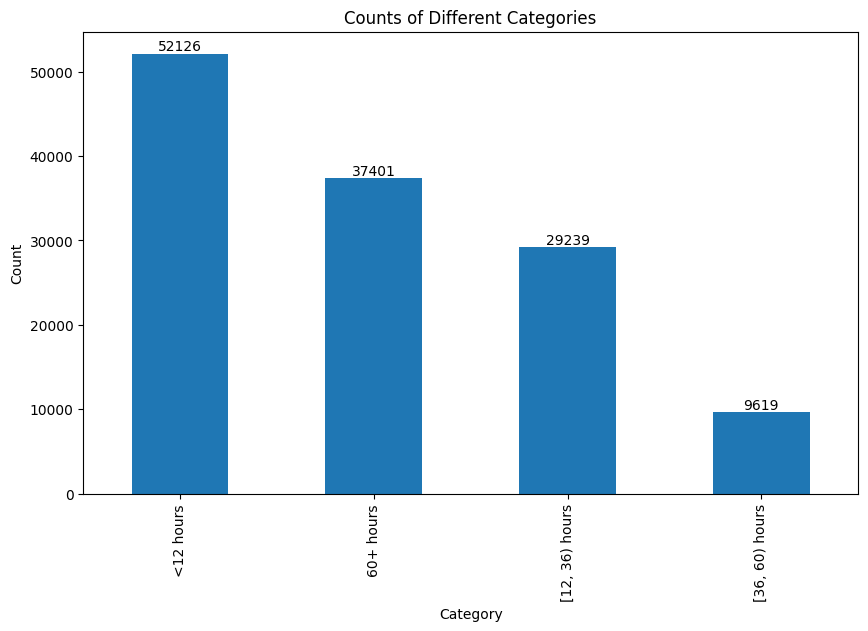

In [79]:
import matplotlib.pyplot as plt

category_counts = data_2['LOS 4 groups'].value_counts()

# Create the bar chart
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Counts of Different Categories')
plt.xlabel('Category')
plt.ylabel('Count')

for i in range(len(category_counts)):
    plt.annotate(str(category_counts[i]), xy=(i, category_counts[i]), ha='center', va='bottom')

plt.show()

In [80]:
print(data_2.shape)
category_counts = data_2.groupby('LOS 4 groups').size()
print(category_counts)
min_count = category_counts.min()
print(min_count)

(128385, 29)
LOS 4 groups
60+ hours         37401
<12 hours         52126
[12, 36) hours    29239
[36, 60) hours     9619
dtype: int64
9619


In [81]:
def sample_rows(df, n):
    sampled_ids = set()
    sampled_df = pd.DataFrame()
    
    for _, row in df.iterrows():
        if row['ID'] not in sampled_ids and len(sampled_df) < n:
            id_rows = df[df['ID'] == row['ID']]
            sampled_ids.add(row['ID'])
            sampled_df = pd.concat([sampled_df, id_rows])
    
    return sampled_df

balanced_df_post_op = pd.DataFrame()

for category in category_counts.index:
    category_df = data_2[data_2['LOS 4 groups'] == category]
    print(category_df.shape)
    sampled_category_df = sample_rows(category_df, min_count)
    # print(sampled_category_df)
    balanced_df_post_op = pd.concat([balanced_df_post_op, sampled_category_df])

# print(balanced_df)

(37401, 29)
(52126, 29)
(29239, 29)
(9619, 29)


C:\Users\ssriram1\AppData\Local\Temp\ipykernel_21052\1219074422.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(str(category_counts[i]), xy=(i, category_counts[i]), ha='center', va='bottom')


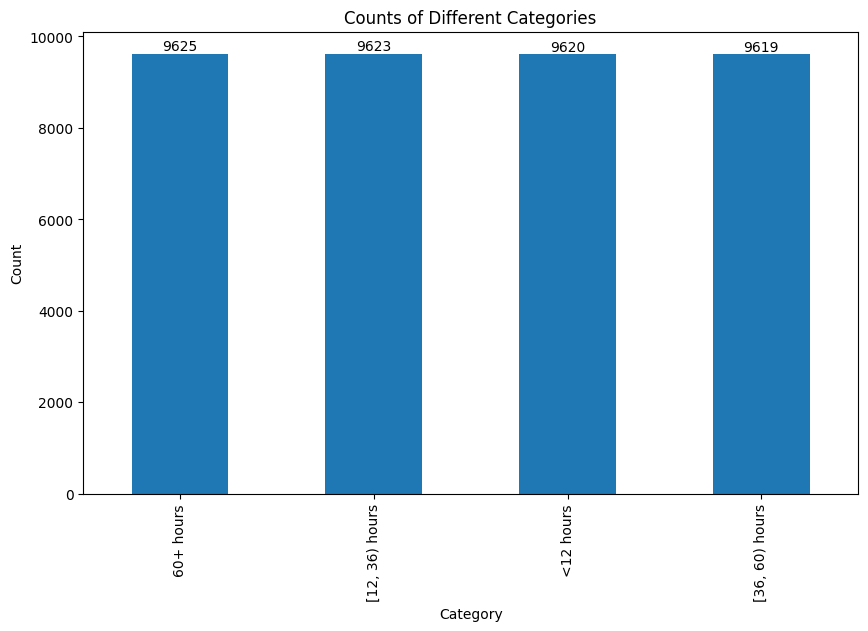

In [82]:
import matplotlib.pyplot as plt

category_counts = balanced_df_post_op['LOS 4 groups'].value_counts()

# Create the bar chart
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Counts of Different Categories')
plt.xlabel('Category')
plt.ylabel('Count')

for i in range(len(category_counts)):
    plt.annotate(str(category_counts[i]), xy=(i, category_counts[i]), ha='center', va='bottom')

plt.show()

In [83]:
data_3 = data_2.copy()

In [84]:
data_2 = data_2.drop(columns=['Estimated Case Duration', 'Primary Service (Rolled Up)', 'Panel Service (Rolled Up)', 'Panel Service'])
balanced_df_post_op = balanced_df_post_op.drop(columns=['Estimated Case Duration', 'Primary Service (Rolled Up)', 'Panel Service (Rolled Up)', 'Panel Service'])

In [85]:
print(data_2.shape)
print(balanced_df_post_op.shape)

(128385, 25)
(38487, 25)


In [86]:
nan_counts = data_2.isnull().sum()

# Display the count of NaN values for each feature
print("Number of NaN values in each feature:")
print(nan_counts)

Number of NaN values in each feature:
ID                              0
Age at Surgery                  0
BMI                             0
Sex                             0
Ethnicity                       0
Primary Race                    0
Surgery Diagnosis Name          0
Location                        0
Primary Service                 0
Patient Class                   0
Anesthesia Type                 0
ASA Status                      0
Primary Surgeon ID              0
Primary Procedure Name          0
Robotic Case?                   0
Procedure Name                  0
Scheduled?                      0
Performed?                      0
Procedure Panel                 0
Panel Primary Surgeon ID        0
Scheduled Room Duration         0
Intraop Minutes                 0
LOS 4 groups                    0
Total Scheduled Panel Length    0
Total Panel Default Length      0
dtype: int64


## Post OP Features

## Encoding

In [87]:
columns_to_encode = [
    'Sex', 'Ethnicity', 'Primary Race', 'ASA Status','Patient Class', 'Anesthesia Type', 'Robotic Case?',
    'Scheduled?','Performed?', 'Procedure Panel', 'Primary Surgeon ID', 'Panel Primary Surgeon ID',
    'Surgery Diagnosis Name', 'Primary Service', 'Primary Procedure Name', 'Procedure Name','Location', 'ID'
]

# One-hot encode the columns using pd.get_dummies
data_2_encoded = pd.get_dummies(data_2, columns=columns_to_encode, drop_first=True)
balanced_df_post_op_encoded = pd.get_dummies(balanced_df_post_op, columns=columns_to_encode, drop_first=True)

In [88]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data_2_encoded['LOS 4 groups_encoded'] = label_encoder.fit_transform(data_2_encoded['LOS 4 groups'])
balanced_df_post_op_encoded['LOS 4 groups_encoded'] = label_encoder.fit_transform(balanced_df_post_op_encoded['LOS 4 groups'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping for 'LOS 4 groups':", label_mapping)

Label Mapping for 'LOS 4 groups': {'60+ hours': 0, '<12 hours': 1, '[12, 36) hours': 2, '[36, 60) hours': 3}


In [89]:
print(data_2_encoded.shape)
print(balanced_df_post_op_encoded.shape)

(128385, 55287)
(38487, 19688)


In [90]:
nan_counts = balanced_df_post_op_encoded.isnull().sum()

# Filter columns where the count of NaN values is greater than 0
columns_with_nan = nan_counts[nan_counts > 0]

# Display the count of NaN values for these features
print("Features with NaN values and their counts:")
print(columns_with_nan)

Features with NaN values and their counts:
Series([], dtype: int64)


## XGB on Unbalanced PostOP Dataset

In [91]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import xgboost as xgb

# X contains all the features except the target column 'LOS 4 groups_encoded'
X = data_2_encoded.drop(columns=['LOS 4 groups_encoded', 'LOS 4 groups'])
y = data_2_encoded['LOS 4 groups_encoded']

# Clean the column names to remove any illegal characters
X.columns = [str(col).replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X.columns]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss')

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for training data
cv_train_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Print cross-validation results for training data
print("Cross-Validation Training Scores:", cv_train_scores)
print("Mean Cross-Validation Training Score:", np.mean(cv_train_scores))
print("Standard Deviation of Cross-Validation Training Scores:", np.std(cv_train_scores))

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = model.predict(X_train)

# Predict on the test set
y_test_pred = model.predict(X_test)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\nTraining Accuracy:", train_accuracy)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Print detailed evaluation metrics for the test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, y_test_pred))

## XGB on Balanced PostOP Dataset

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import xgboost as xgb

# X contains all the features except the target column 'LOS 4 groups_encoded'
X = balanced_df_post_op_encoded.drop(columns=['LOS 4 groups_encoded', 'LOS 4 groups','ID'])
y = balanced_df_post_op_encoded['LOS 4 groups_encoded']

# Clean the column names to remove any illegal characters
X.columns = [str(col).replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X.columns]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss')

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for training data
cv_train_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Print cross-validation results for training data
print("Cross-Validation Training Scores:", cv_train_scores)
print("Mean Cross-Validation Training Score:", np.mean(cv_train_scores))
print("Standard Deviation of Cross-Validation Training Scores:", np.std(cv_train_scores))

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = model.predict(X_train)

# Predict on the test set
y_test_pred = model.predict(X_test)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\nTraining Accuracy:", train_accuracy)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Print detailed evaluation metrics for the test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, y_test_pred))


## Bayes Optimisation

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from bayes_opt import BayesianOptimization
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Assuming balanced_df_post_op_encoded is already defined
X = balanced_df_post_op_encoded.drop(columns=['LOS 4 groups_encoded', 'LOS 4 groups', 'ID'])
y = balanced_df_post_op_encoded['LOS 4 groups_encoded']

# Clean the column names to remove any illegal characters
X.columns = [str(col).replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X.columns]

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the function to optimize
def xgb_cv(n_estimators, max_depth, learning_rate, gamma, min_child_weight):
    model = XGBClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        gamma=gamma,
        min_child_weight=min_child_weight,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'  # Use appropriate eval_metric depending on the problem
    )
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return np.mean(cv_scores)

# Set the parameter bounds for Bayesian Optimization
param_bounds = {
    'n_estimators': (50, 200),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'gamma': (0, 5),
    'min_child_weight': (1, 10)
}

# Perform Bayesian Optimization
optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds=param_bounds,
    random_state=42
)
optimizer.maximize(init_points=10, n_iter=50)

# Get the best parameters
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])

print("Best parameters found by Bayesian Optimization:")
print(best_params)

# Train the final model with the best parameters
best_xgb = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    gamma=best_params['gamma'],
    min_child_weight=best_params['min_child_weight'],
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
best_xgb.fit(X_train, y_train)

# Predict on the test set
y_pred = best_xgb.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


## Tuned XGBoost with Balanced PostOP Dataset

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import xgboost as xgb

X = balanced_df_post_op_encoded.drop(columns=['LOS 4 groups_encoded', 'LOS 4 groups'])
y = balanced_df_post_op_encoded['LOS 4 groups_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss', learning_rate=np.float64(0.19066019996206915), max_depth=7, n_estimators=102)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for training data
cv_train_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Print cross-validation results for training data
print("Cross-Validation Training Scores:", cv_train_scores)
print("Mean Cross-Validation Training Score:", np.mean(cv_train_scores))
print("Standard Deviation of Cross-Validation Training Scores:", np.std(cv_train_scores))

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = model.predict(X_train)

# Predict on the test set
y_test_pred = model.predict(X_test)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\nTraining Accuracy:", train_accuracy)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Print detailed evaluation metrics for the test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, y_test_pred))


## Forward Selection - using 24 features

In [101]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import LabelEncoder
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
# import matplotlib.pyplot as plt

# X = balanced_df_post_op.drop(columns=['LOS 4 groups','ID'])
# y = balanced_df_post_op['LOS 4 groups']

# # Encode the target variable
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)
# label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# print("Label Mapping for 'LOS 4 groups':", label_mapping)

# # Define numerical features
# numerical_features = ['Age at Surgery', 'BMI', 'Scheduled Room Duration', 'Intraop Minutes', 'Total Scheduled Panel Length', 'Total Panel Default Length']

# # Identify non-numerical features
# non_numerical_features = [feature for feature in X.columns if feature not in numerical_features]

# # Initialize cross-validation
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Initialize the XGBoost classifier
# model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss')

# # Initialize the feature set and tracking variables
# selected_features = []
# best_accuracy = 0
# feature_set = list(X.columns)

# # To store the results
# results = []

# # Set the accuracy threshold
# accuracy_threshold = 0.98

# # Track encoded features
# encoded_features = []

# # Iterate until no more improvements or accuracy plateaus
# while feature_set:
#     best_feature = None
#     best_feature_accuracy = 0
    
#     for feature in feature_set:
#         print(feature)
#         # Prepare the feature subset
#         current_features = selected_features + [feature]
#         X_subset = X[current_features]
        
#         # Identify features to be encoded
#         features_to_encode = [f for f in current_features if f not in numerical_features]
        
#         # Apply one-hot encoding to non-numerical features
#         if features_to_encode:
#             X_subset = pd.get_dummies(X_subset, columns=features_to_encode, drop_first=True)
#         else:
#             X_subset = X_subset

#         # Clean the column names to remove any illegal characters
#         X_subset.columns = [str(col).replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X_subset.columns]
        
#         # Evaluate the model using cross-validation
#         scores = cross_val_score(model, X_subset, y, cv=cv, scoring='accuracy')
#         mean_accuracy = scores.mean()
        
#         # Check if this feature improves accuracy
#         if mean_accuracy > best_feature_accuracy:
#             best_feature_accuracy = mean_accuracy
#             best_feature = feature
    
#     # If adding the best feature improves accuracy, update the selected features
#     if best_feature_accuracy > best_accuracy:
#         selected_features.append(best_feature)
#         feature_set.remove(best_feature)
#         results.append((len(selected_features), best_accuracy))
#         best_accuracy = best_feature_accuracy
#         print(f"Added feature: {best_feature}, Accuracy: {best_accuracy:.4f}")
        
#         # Check if the accuracy meets the threshold
#         if best_accuracy >= accuracy_threshold:
#             print(f"Threshold accuracy of {accuracy_threshold} reached.")
#             break
#     else:
#         # Stop if no improvement
#         break

# # Convert results to a DataFrame for better visualization
# results_df = pd.DataFrame(results, columns=['Number of Features', 'Accuracy'])

# # Print the results
# print("\nFinal Selected Features:")
# print(selected_features)

# # Print detailed results
# print("\nResults:")
# print(results_df)

# # Plot the results to visualize the accuracy vs number of features
# plt.figure(figsize=(12, 6))
# plt.plot(results_df['Number of Features'], results_df['Accuracy'], marker='o')
# plt.xlabel('Number of Features')
# plt.ylabel('Accuracy')
# plt.title('Accuracy vs Number of Features')
# plt.grid(True)
# plt.show()


In [125]:
# Import necessary library
from sklearn.preprocessing import LabelEncoder

# Select specific columns from the balanced dataset for further processing
final_selected_features = [
    'Primary Procedure Name', 'Intraop Minutes', 'Primary Surgeon ID', 'Patient Class', 
    'Total Panel Default Length', 'Primary Service', 'Age at Surgery', 'BMI', 
     'Primary Race', 'LOS 4 groups', 'Sex','ID'
]

# Create a new DataFrame with only the selected features
balanced_final_post_op = balanced_df_post_op[final_selected_features]

# List of categorical columns that need to be encoded
columns_to_encode = [
    'Sex', 'Primary Race', 'Patient Class',  'Primary Surgeon ID',  'Primary Service', 'Primary Procedure Name'
]

# Apply one-hot encoding to the specified categorical columns
balanced_final_post_op_encoded = pd.get_dummies(balanced_final_post_op, columns=columns_to_encode, drop_first=True)

# Initialize a LabelEncoder for encoding the target variable
label_encoder = LabelEncoder()

# Encode the 'LOS 4 groups' column and add it to the DataFrame
balanced_final_post_op_encoded['LOS 4 groups_encoded'] = label_encoder.fit_transform(balanced_final_post_op['LOS 4 groups'])

# Create a dictionary mapping original class names to their encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the label mapping for the 'LOS 4 groups' column
print("Label Mapping for 'LOS 4 groups':", label_mapping)

# Print the shape of the encoded DataFrame to verify the transformation
print(balanced_final_post_op_encoded.shape)


Label Mapping for 'LOS 4 groups': {'60+ hours': 0, '<12 hours': 1, '[12, 36) hours': 2, '[36, 60) hours': 3}
(38487, 4370)


## XGB on Selected Feature Set

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# X contains all the features except the target column 'LOS 4 groups_encoded'
X = balanced_final_post_op_encoded.drop(columns=['LOS 4 groups_encoded', 'LOS 4 groups','ID'])
y = balanced_final_post_op_encoded['LOS 4 groups_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the XGBoost classifier
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss')

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for training data
cv_train_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Print cross-validation results for training data
print("Cross-Validation Training Scores:", cv_train_scores)
print("Mean Cross-Validation Training Score:", np.mean(cv_train_scores))
print("Standard Deviation of Cross-Validation Training Scores:", np.std(cv_train_scores))

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = model.predict(X_train)

# Predict on the test set
y_test_pred = model.predict(X_test)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\nTraining Accuracy:", train_accuracy)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Print detailed evaluation metrics for the test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, y_test_pred))


## Misclassification Analysis

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

X = balanced_final_post_op_encoded.drop(columns=['LOS 4 groups_encoded', 'LOS 4 groups', 'ID'])
y = balanced_final_post_op_encoded['LOS 4 groups_encoded']
ids = balanced_final_post_op_encoded['ID']

# Clean the column names to remove any illegal characters
X.columns = [str(col).replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X.columns]

# Splitting the data
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X, y, ids, test_size=0.2, random_state=42, stratify=y)

# Initialize the XGBoost classifier
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss')

# Perform Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and calculate scores
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Train the model on the training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Stratified K-Fold Cross-Validation Scores:", cv_scores)
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:", accuracy_score(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Add the true labels, predictions, and IDs to a DataFrame
results_df = pd.DataFrame({
    'True_Label': y_test,
    'Pred_Label': y_pred,
    'ID': ids_test
})

# Identify misclassified samples
misclassified_df = results_df[results_df['True_Label'] != results_df['Pred_Label']]

# Calculate percentage of misclassifications for each true label
misclassification_percentage = (misclassified_df.groupby('True_Label').size() / results_df.groupby('True_Label').size()) * 100

print("\nMisclassification Percentage by Class:")
print(misclassification_percentage)

# Find IDs misclassified multiple times
misclassified_id_counts = misclassified_df.groupby('ID').size()
ids_multiple_misclassifications = misclassified_id_counts[misclassified_id_counts > 1].index

print("\nIDs Misclassified Multiple Times:")
print(ids_multiple_misclassifications)


## Analysis of Misclassified IDs

In [ ]:
results_df = pd.DataFrame({
    'True_Label': y_test,
    'Pred_Label': y_pred,
    'ID': ids_test
})

# Identify misclassified samples
misclassified_df = results_df[results_df['True_Label'] != results_df['Pred_Label']]

# Calculate counts for each class
misclassified_id_counts = misclassified_df.groupby(['True_Label', 'ID']).size()
misclassified_id_counts = misclassified_id_counts.reset_index(name='Count')

# Count of IDs misclassified once and multiple times for each class
unique_id_counts = misclassified_id_counts[misclassified_id_counts['Count'] == 1]
multiple_id_counts = misclassified_id_counts[misclassified_id_counts['Count'] > 1]

# Aggregated counts for each class
unique_id_counts_per_class = unique_id_counts.groupby('True_Label').size()
multiple_id_counts_per_class = multiple_id_counts.groupby('True_Label').size()

# Prepare data for bar charts
class_labels = unique_id_counts_per_class.index
unique_counts = unique_id_counts_per_class.reindex(class_labels, fill_value=0)
multiple_counts = multiple_id_counts_per_class.reindex(class_labels, fill_value=0)

# DataFrames for plotting
unique_df = pd.DataFrame({
    'Class': unique_counts.index,
    'Unique Misclassified IDs': unique_counts.values
})

multiple_df = pd.DataFrame({
    'Class': multiple_counts.index,
    'Multiple Misclassifications': multiple_counts.values
})

# Plotting side-by-side bar charts with counts
plt.figure(figsize=(14, 7))

# Plot unique misclassified IDs
plt.subplot(1, 2, 1)
bars = plt.bar(unique_df['Class'].astype(str), unique_df['Unique Misclassified IDs'], color='skyblue')
plt.xlabel('True Label')
plt.ylabel('Count of Unique Misclassified IDs')
plt.title('Unique Misclassified IDs per Class')
plt.xticks(rotation=45)

# Add counts on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

# Plot multiple misclassifications
plt.subplot(1, 2, 2)
bars = plt.bar(multiple_df['Class'].astype(str), multiple_df['Multiple Misclassifications'], color='salmon')
plt.xlabel('True Label')
plt.ylabel('Count of Multiple Misclassifications')
plt.title('IDs Misclassified Multiple Times per Class')
plt.xticks(rotation=45)

# Add counts on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Assuming `misclassification_percentage` is a pandas Series from the previous analysis

# Plotting the bar chart
plt.figure(figsize=(10, 6))
misclassification_percentage.plot(kind='bar', color='skyblue')
plt.title('Misclassification Percentage by Class')
plt.xlabel('True Label')
plt.ylabel('Misclassification Percentage (%)')
plt.xticks(rotation=0)  # Rotate x-axis labels to be horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Most Common Misclassifications

In [ ]:
# Add the true labels, predictions, and IDs to a DataFrame
results_df = pd.DataFrame({
    'True_Label': y_test,
    'Pred_Label': y_pred,
    'ID': ids_test
})

# Identify misclassified samples
misclassified_df = results_df[results_df['True_Label'] != results_df['Pred_Label']]

# For each true class, determine the most frequent misclassification
most_common_misclassifications = {}
for true_class in misclassified_df['True_Label'].unique():
    class_misclassifications = misclassified_df[misclassified_df['True_Label'] == true_class]
    misclass_counts = class_misclassifications['Pred_Label'].value_counts()
    most_common_class = misclass_counts.idxmax()
    most_common_count = misclass_counts.max()
    most_common_misclassifications[true_class] = {
        'Most_Common_Class': most_common_class,
        'Count': most_common_count
    }

# Display the results
most_common_df = pd.DataFrame(most_common_misclassifications).T
print("Most Common Misclassifications:")
print(most_common_df)

# Optional: Plot the results for visualization
import matplotlib.pyplot as plt

# Plotting the most common misclassifications
plt.figure(figsize=(12, 8))
plt.bar(most_common_df.index.astype(str), most_common_df['Count'], color='lightcoral')
plt.xlabel('True Label')
plt.ylabel('Count of Most Common Misclassifications')
plt.title('Most Common Misclassification Counts per True Class')
plt.xticks(rotation=45)

# Annotate bars with counts
for i, count in enumerate(most_common_df['Count']):
    plt.text(i, count + 0.5, int(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Tuned XGB on Selected Feature Set

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# X contains all the features except the target column 'LOS 4 groups_encoded'
X = balanced_final_post_op_encoded.drop(columns=['LOS 4 groups_encoded', 'LOS 4 groups','ID'])
y = balanced_final_post_op_encoded['LOS 4 groups_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss', learning_rate=np.float64(0.19066019996206915), max_depth=7, n_estimators=102)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for training data
cv_train_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Print cross-validation results for training data
print("Cross-Validation Training Scores:", cv_train_scores)
print("Mean Cross-Validation Training Score:", np.mean(cv_train_scores))
print("Standard Deviation of Cross-Validation Training Scores:", np.std(cv_train_scores))

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = model.predict(X_train)

# Predict on the test set
y_test_pred = model.predict(X_test)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\nTraining Accuracy:", train_accuracy)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Print detailed evaluation metrics for the test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, y_test_pred))


## Backward Selection - 24 Features

In [128]:
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
# import matplotlib.pyplot as plt

# # Define your numerical features
# numerical_features = ['Age at Surgery', 'BMI', 'Scheduled Room Duration', 'Intraop Minutes', 'Total Scheduled Panel Length', 'Total Panel Default Length']


# X = balanced_df_post_op.drop(columns=['LOS 4 groups','ID'])
# y = balanced_df_post_op['LOS 4 groups']

# # Encode the target variable
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)
# label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# print("Label Mapping for 'LOS 4 groups':", label_mapping)

# # Identify non-numerical features
# non_numerical_features = [feature for feature in X.columns if feature not in numerical_features]

# # Initialize cross-validation
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Initialize the XGBoost model
# model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss')

# # Initialize the feature set and tracking variables
# selected_features = list(X.columns)
# best_accuracy = 0
# results = []

# # Set the accuracy threshold
# accuracy_threshold = 0.75

# # Iterate while we have features to remove
# while selected_features:
#     best_feature = None
#     best_feature_accuracy = 0

#     for feature in selected_features:
#         # Prepare the feature subset
#         current_features = [f for f in selected_features if f != feature]
#         print(current_features)
#         X_subset = X[current_features]

#         # Identify features to be encoded
#         features_to_encode = [f for f in current_features if f not in numerical_features]

#         # Apply one-hot encoding to non-numerical features
#         if features_to_encode:
#             X_subset = pd.get_dummies(X_subset, columns=features_to_encode, drop_first=True)

#         # Clean the column names to remove any illegal characters
#         X_subset.columns = [str(col).replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X_subset.columns]

#         # Evaluate the model using cross-validation
#         scores = cross_val_score(model, X_subset, y, cv=cv, scoring='accuracy')
#         mean_accuracy = scores.mean()

#         # Check if this feature removal improves accuracy
#         if mean_accuracy > best_feature_accuracy:
#             best_feature_accuracy = mean_accuracy
#             best_feature = feature

#     # If removing the worst feature improves or maintains accuracy, update the selected features
#     if best_feature_accuracy >= best_accuracy:
#         if best_feature_accuracy > best_accuracy:
#             best_accuracy = best_feature_accuracy
#         selected_features.remove(best_feature)
#         results.append((len(selected_features), best_accuracy))
#         print(f"Removed feature: {best_feature}, Accuracy: {best_accuracy:.4f}")

#         # Check if the accuracy meets the threshold
#         if best_accuracy < accuracy_threshold:
#             print(f"Threshold accuracy of {accuracy_threshold} reached.")
#             break
#     else:
#         # Stop if no improvement
#         break

# # Convert results to a DataFrame for better visualization
# results_df = pd.DataFrame(results, columns=['Number of Features', 'Accuracy'])

# # Print the results
# print("\nFinal Selected Features:")
# print(selected_features)

# # Print detailed results
# print("\nResults:")
# print(results_df)

# # Plot the results to visualize the accuracy vs number of features
# plt.figure(figsize=(12, 6))
# plt.plot(results_df['Number of Features'], results_df['Accuracy'], marker='o')
# plt.xlabel('Number of Features')
# plt.ylabel('Accuracy')
# plt.title('Accuracy vs Number of Features')
# plt.grid(True)
# plt.show()


In [137]:
# Import necessary library
from sklearn.preprocessing import LabelEncoder

# Select specific columns from the balanced dataset for further processing
final_selected_features = ['Age at Surgery', 'BMI', 'Sex', 'Primary Race', 'Surgery Diagnosis Name', 
                           'Location', 'Primary Service', 'Patient Class', 'ASA Status', 'Primary Surgeon ID',
                            'Primary Procedure Name', 'Robotic Case?', 'Panel Primary Surgeon ID', 'Scheduled Room Duration', 
                           'Intraop Minutes', 'Total Scheduled Panel Length', 'Total Panel Default Length', 'LOS 4 groups','ID']

# Create a new DataFrame with only the selected features
balanced_final_post_op_bs = balanced_df_post_op[final_selected_features]

# List of categorical columns that need to be encoded
columns_to_encode = ['Sex', 'Primary Race', 'Surgery Diagnosis Name', 
                           'Location', 'Primary Service', 'Patient Class', 'ASA Status', 'Primary Surgeon ID',
                            'Primary Procedure Name', 'Robotic Case?', 'Panel Primary Surgeon ID']

# Apply one-hot encoding to the specified categorical columns
balanced_final_post_op_encoded_bs = pd.get_dummies(balanced_final_post_op_bs, columns=columns_to_encode, drop_first=True)

# Initialize a LabelEncoder for encoding the target variable
label_encoder = LabelEncoder()

# Encode the 'LOS 4 groups' column and add it to the DataFrame
balanced_final_post_op_encoded_bs['LOS 4 groups_encoded'] = label_encoder.fit_transform(balanced_final_post_op_bs['LOS 4 groups'])

# Create a dictionary mapping original class names to their encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the label mapping for the 'LOS 4 groups' column
print("Label Mapping for 'LOS 4 groups':", label_mapping)

# Print the shape of the encoded DataFrame to verify the transformation
print(balanced_final_post_op_encoded_bs.shape)


Label Mapping for 'LOS 4 groups': {'60+ hours': 0, '<12 hours': 1, '[12, 36) hours': 2, '[36, 60) hours': 3}
(38487, 4727)


## XGB on Selected Feature Set

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# X contains all the features except the target column 'LOS 4 groups_encoded'
X = balanced_final_post_op_encoded_bs.drop(columns=['LOS 4 groups_encoded', 'LOS 4 groups','ID'])
y = balanced_final_post_op_encoded_bs['LOS 4 groups_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss')

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for training data
cv_train_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Print cross-validation results for training data
print("Cross-Validation Training Scores:", cv_train_scores)
print("Mean Cross-Validation Training Score:", np.mean(cv_train_scores))
print("Standard Deviation of Cross-Validation Training Scores:", np.std(cv_train_scores))

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = model.predict(X_train)

# Predict on the test set
y_test_pred = model.predict(X_test)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\nTraining Accuracy:", train_accuracy)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Print detailed evaluation metrics for the test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, y_test_pred))


## Tuned XGB on Selected Feature Set

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# X contains all the features except the target column 'LOS 4 groups_encoded'
X = balanced_final_post_op_encoded_bs.drop(columns=['LOS 4 groups_encoded', 'LOS 4 groups','ID'])
y = balanced_final_post_op_encoded_bs['LOS 4 groups_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss', learning_rate=np.float64(0.19066019996206915), max_depth=7, n_estimators=102)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for training data
cv_train_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Print cross-validation results for training data
print("Cross-Validation Training Scores:", cv_train_scores)
print("Mean Cross-Validation Training Score:", np.mean(cv_train_scores))
print("Standard Deviation of Cross-Validation Training Scores:", np.std(cv_train_scores))

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = model.predict(X_train)

# Predict on the test set
y_test_pred = model.predict(X_test)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\nTraining Accuracy:", train_accuracy)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Print detailed evaluation metrics for the test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, y_test_pred))


## PreOP Features

In [109]:
data_3 = data_3[data_3['Scheduled?'] == 'Y']

print(data_3.shape)
category_counts = data_3.groupby('LOS 4 groups').size()
print(category_counts)
min_count = category_counts.min()
print(min_count)

(108324, 29)
LOS 4 groups
60+ hours         28343
<12 hours         46878
[12, 36) hours    25502
[36, 60) hours     7601
dtype: int64
7601


C:\Users\ssriram1\AppData\Local\Temp\ipykernel_23608\4155339533.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(str(category_counts[i]), xy=(i, category_counts[i]), ha='center', va='bottom')


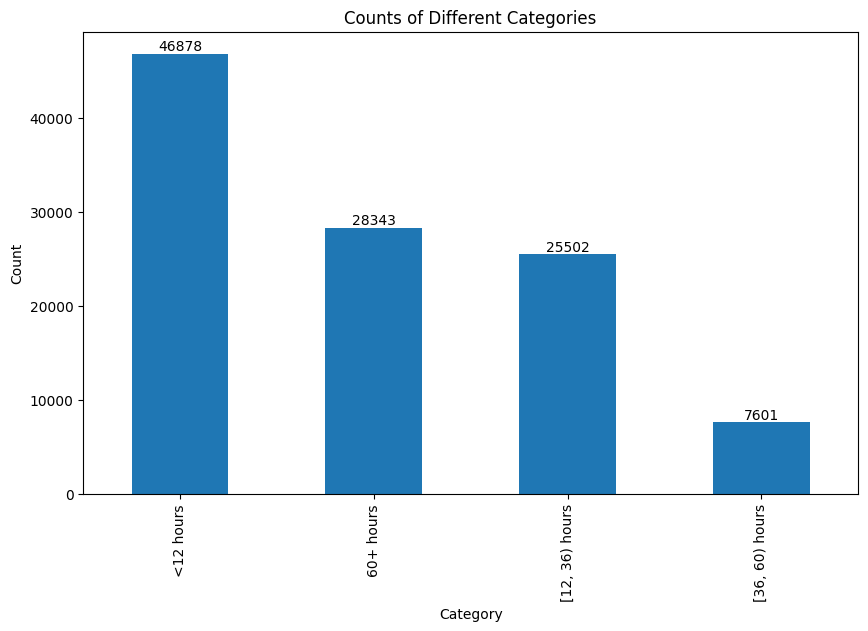

In [110]:
import matplotlib.pyplot as plt

category_counts = data_3['LOS 4 groups'].value_counts()

# Create the bar chart
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Counts of Different Categories')
plt.xlabel('Category')
plt.ylabel('Count')

for i in range(len(category_counts)):
    plt.annotate(str(category_counts[i]), xy=(i, category_counts[i]), ha='center', va='bottom')

plt.show()

In [111]:
def sample_rows(df, n):
    sampled_ids = set()
    sampled_df = pd.DataFrame()
    
    for _, row in df.iterrows():
        if row['ID'] not in sampled_ids and len(sampled_df) < n:
            id_rows = df[df['ID'] == row['ID']]
            sampled_ids.add(row['ID'])
            sampled_df = pd.concat([sampled_df, id_rows])
    
    return sampled_df

balanced_df_pre_op = pd.DataFrame()

for category in category_counts.index:
    category_df = data_3[data_3['LOS 4 groups'] == category]
    print(category_df.shape)
    sampled_category_df = sample_rows(category_df, min_count)
    # print(sampled_category_df)
    balanced_df_pre_op = pd.concat([balanced_df_pre_op, sampled_category_df])

# print(balanced_df)

(46878, 29)
(28343, 29)
(25502, 29)
(7601, 29)


C:\Users\ssriram1\AppData\Local\Temp\ipykernel_23608\3989700876.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(str(category_counts[i]), xy=(i, category_counts[i]), ha='center', va='bottom')


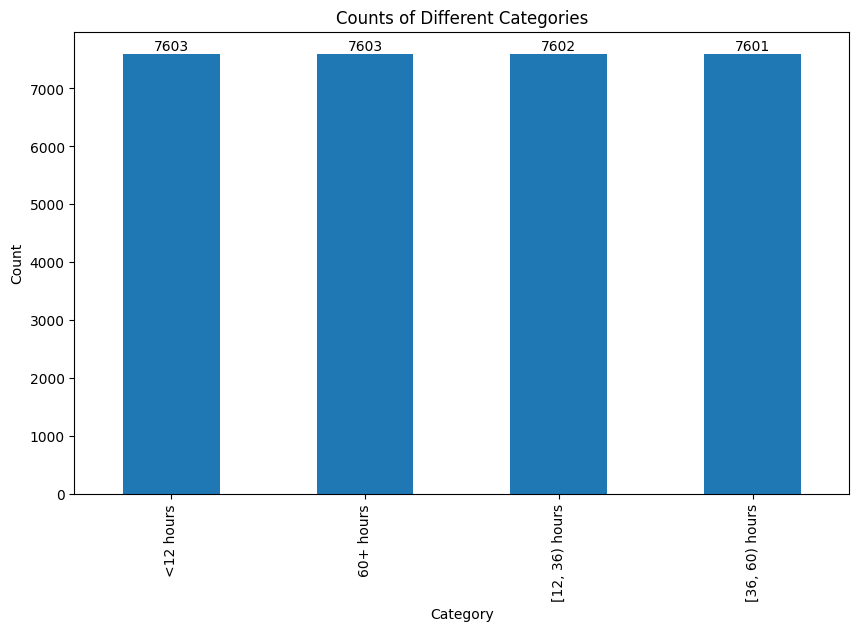

In [112]:
import matplotlib.pyplot as plt

category_counts = balanced_df_pre_op['LOS 4 groups'].value_counts()

# Create the bar chart
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Counts of Different Categories')
plt.xlabel('Category')
plt.ylabel('Count')

for i in range(len(category_counts)):
    plt.annotate(str(category_counts[i]), xy=(i, category_counts[i]), ha='center', va='bottom')

plt.show()

In [113]:
data_3 = data_3.drop(columns=[ 'Estimated Case Duration', 'Primary Service (Rolled Up)', 'Panel Service (Rolled Up)', 'Panel Service', 'Intraop Minutes', 'Scheduled?', 'Location', 'Patient Class'])
balanced_df_pre_op = balanced_df_pre_op.drop(columns=[ 'Estimated Case Duration', 'Primary Service (Rolled Up)', 'Panel Service (Rolled Up)', 'Panel Service', 'Intraop Minutes', 'Scheduled?', 'Location', 'Patient Class'])

In [114]:
print(data_3.shape)
print(balanced_df_pre_op.shape)

(108324, 20)
(30409, 20)


In [115]:
balanced_df_pre_op.columns

Index(['Age at Surgery', 'BMI', 'Sex', 'Ethnicity', 'Primary Race',
       'Surgery Diagnosis Name', 'Primary Service', 'Anesthesia Type',
       'ASA Status', 'Primary Surgeon ID', 'Primary Procedure Name',
       'Robotic Case?', 'Procedure Name', 'Performed?', 'Procedure Panel',
       'Panel Primary Surgeon ID', 'Scheduled Room Duration', 'LOS 4 groups',
       'Total Scheduled Panel Length', 'Total Panel Default Length'],
      dtype='object')

In [116]:
columns_to_encode = [
    'Sex', 'Ethnicity', 'Primary Race', 'ASA Status', 'Anesthesia Type', 'Robotic Case?',
    'Performed?', 'Procedure Panel', 'Primary Surgeon ID', 'Panel Primary Surgeon ID',
    'Surgery Diagnosis Name', 'Primary Service', 'Primary Procedure Name', 'Procedure Name']

# One-hot encode the columns using pd.get_dummies
data_3_encoded = pd.get_dummies(data_3, columns=columns_to_encode, drop_first=True)
balanced_df_pre_op_encoded = pd.get_dummies(balanced_df_pre_op, columns=columns_to_encode, drop_first=True)

In [117]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data_3_encoded['LOS 4 groups_encoded'] = label_encoder.fit_transform(data_3_encoded['LOS 4 groups'])
balanced_df_pre_op_encoded['LOS 4 groups_encoded'] = label_encoder.fit_transform(balanced_df_pre_op_encoded['LOS 4 groups'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping for 'LOS 4 groups':", label_mapping)

Label Mapping for 'LOS 4 groups': {'60+ hours': 0, '<12 hours': 1, '[12, 36) hours': 2, '[36, 60) hours': 3}


## XGB on Unbalanced PreOP Dataset

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# X contains all the features except the target column 'LOS 4 groups_encoded'
X = data_3_encoded.drop(columns=['LOS 4 groups_encoded', 'LOS 4 groups'])
y = data_3_encoded['LOS 4 groups_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss')

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for training data
cv_train_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Print cross-validation results for training data
print("Cross-Validation Training Scores:", cv_train_scores)
print("Mean Cross-Validation Training Score:", np.mean(cv_train_scores))
print("Standard Deviation of Cross-Validation Training Scores:", np.std(cv_train_scores))

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = model.predict(X_train)

# Predict on the test set
y_test_pred = model.predict(X_test)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\nTraining Accuracy:", train_accuracy)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Print detailed evaluation metrics for the test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, y_test_pred))


## XGB on Balanced PreOP Dataset

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# X contains all the features except the target column 'LOS 4 groups_encoded'
X = balanced_df_pre_op_encoded.drop(columns=['LOS 4 groups_encoded', 'LOS 4 groups','ID'])
y = balanced_df_pre_op_encoded['LOS 4 groups_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss')

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for training data
cv_train_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Print cross-validation results for training data
print("Cross-Validation Training Scores:", cv_train_scores)
print("Mean Cross-Validation Training Score:", np.mean(cv_train_scores))
print("Standard Deviation of Cross-Validation Training Scores:", np.std(cv_train_scores))

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = model.predict(X_train)

# Predict on the test set
y_test_pred = model.predict(X_test)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\nTraining Accuracy:", train_accuracy)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Print detailed evaluation metrics for the test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, y_test_pred))


## Bayes Optimisation

In [ ]:
# import pandas as pd
# import numpy as np
# from xgboost import XGBClassifier
# from sklearn.model_selection import cross_val_score, train_test_split
# from bayes_opt import BayesianOptimization
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# # Assuming balanced_df_post_op_encoded is already defined
# X = balanced_df_pre_op_encoded.drop(columns=['LOS 4 groups_encoded', 'LOS 4 groups', 'ID'])
# y = balanced_df_pre_op_encoded['LOS 4 groups_encoded']

# # Clean the column names to remove any illegal characters
# X.columns = [str(col).replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X.columns]

# # Splitting the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Define the function to optimize
# def xgb_cv(n_estimators, max_depth, learning_rate, gamma, min_child_weight):
#     model = XGBClassifier(
#         n_estimators=int(n_estimators),
#         max_depth=int(max_depth),
#         learning_rate=learning_rate,
#         gamma=gamma,
#         min_child_weight=min_child_weight,
#         random_state=42,
#         use_label_encoder=False,
#         eval_metric='mlogloss'  # Use appropriate eval_metric depending on the problem
#     )
#     cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
#     return np.mean(cv_scores)

# # Set the parameter bounds for Bayesian Optimization
# param_bounds = {
#     'n_estimators': (50, 200),
#     'max_depth': (3, 10),
#     'learning_rate': (0.01, 0.3),
#     'gamma': (0, 5),
#     'min_child_weight': (1, 10)
# }

# # Perform Bayesian Optimization
# optimizer = BayesianOptimization(
#     f=xgb_cv,
#     pbounds=param_bounds,
#     random_state=42
# )
# optimizer.maximize(init_points=10, n_iter=50)

# # Get the best parameters
# best_params = optimizer.max['params']
# best_params['n_estimators'] = int(best_params['n_estimators'])
# best_params['max_depth'] = int(best_params['max_depth'])

# print("Best parameters found by Bayesian Optimization:")
# print(best_params)

# # Train the final model with the best parameters
# best_xgb = XGBClassifier(
#     n_estimators=best_params['n_estimators'],
#     max_depth=best_params['max_depth'],
#     learning_rate=best_params['learning_rate'],
#     gamma=best_params['gamma'],
#     min_child_weight=best_params['min_child_weight'],
#     random_state=42,
#     use_label_encoder=False,
#     eval_metric='mlogloss'
# )
# best_xgb.fit(X_train, y_train)

# # Predict on the test set
# y_pred = best_xgb.predict(X_test)

# # Evaluate the model
# print("Classification Report:")
# print(classification_report(y_test, y_pred))
# print("Accuracy Score:", accuracy_score(y_test, y_pred))
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred))

## Tuned XGB with Balanced PreOP Dataset

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

X = balanced_df_pre_op_encoded.drop(columns=['LOS 4 groups_encoded', 'LOS 4 groups','ID'])
y = balanced_df_pre_op_encoded['LOS 4 groups_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss', learning_rate=np.float64(0.19066019996206915), max_depth=7, n_estimators=102)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for training data
cv_train_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Print cross-validation results for training data
print("Cross-Validation Training Scores:", cv_train_scores)
print("Mean Cross-Validation Training Score:", np.mean(cv_train_scores))
print("Standard Deviation of Cross-Validation Training Scores:", np.std(cv_train_scores))

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = model.predict(X_train)

# Predict on the test set
y_test_pred = model.predict(X_test)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\nTraining Accuracy:", train_accuracy)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Print detailed evaluation metrics for the test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, y_test_pred))


## Forward Selection - using 20 features

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import LabelEncoder
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
# import matplotlib.pyplot as plt

# X = balanced_df_pre_op.drop(columns=['LOS 4 groups','ID'])
# y = balanced_df_pre_op['LOS 4 groups']

# # Encode the target variable
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)
# label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# print("Label Mapping for 'LOS 4 groups':", label_mapping)

# # Define numerical features
# numerical_features = ['Age at Surgery', 'BMI', 'Scheduled Room Duration', 'Intraop Minutes', 'Total Scheduled Panel Length', 'Total Panel Default Length']

# # Identify non-numerical features
# non_numerical_features = [feature for feature in X.columns if feature not in numerical_features]

# # Initialize cross-validation
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Initialize the XGBoost model
# model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss')

# # Initialize the feature set and tracking variables
# selected_features = []
# best_accuracy = 0
# feature_set = list(X.columns)

# # To store the results
# results = []

# # Set the accuracy threshold
# accuracy_threshold = 0.98

# # Track encoded features
# encoded_features = []

# # Iterate until no more improvements or accuracy plateaus
# while feature_set:
#     best_feature = None
#     best_feature_accuracy = 0
    
#     for feature in feature_set:
#         print(feature)
#         # Prepare the feature subset
#         current_features = selected_features + [feature]
#         X_subset = X[current_features]
        
#         # Identify features to be encoded
#         features_to_encode = [f for f in current_features if f not in numerical_features]
        
#         # Apply one-hot encoding to non-numerical features
#         if features_to_encode:
#             X_subset = pd.get_dummies(X_subset, columns=features_to_encode, drop_first=True)
#         else:
#             X_subset = X_subset

#         # Clean the column names to remove any illegal characters
#         X_subset.columns = [str(col).replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X_subset.columns]
        
#         # Evaluate the model using cross-validation
#         scores = cross_val_score(model, X_subset, y, cv=cv, scoring='accuracy')
#         mean_accuracy = scores.mean()
        
#         # Check if this feature improves accuracy
#         if mean_accuracy > best_feature_accuracy:
#             best_feature_accuracy = mean_accuracy
#             best_feature = feature
    
#     # If adding the best feature improves accuracy, update the selected features
#     if best_feature_accuracy > best_accuracy:
#         selected_features.append(best_feature)
#         feature_set.remove(best_feature)
#         results.append((len(selected_features), best_accuracy))
#         best_accuracy = best_feature_accuracy
#         print(f"Added feature: {best_feature}, Accuracy: {best_accuracy:.4f}")
        
#         # Check if the accuracy meets the threshold
#         if best_accuracy >= accuracy_threshold:
#             print(f"Threshold accuracy of {accuracy_threshold} reached.")
#             break
#     else:
#         # Stop if no improvement
#         break

# # Convert results to a DataFrame for better visualization
# results_df = pd.DataFrame(results, columns=['Number of Features', 'Accuracy'])

# # Print the results
# print("\nFinal Selected Features:")
# print(selected_features)

# # Print detailed results
# print("\nResults:")
# print(results_df)

# # Plot the results to visualize the accuracy vs number of features
# plt.figure(figsize=(12, 6))
# plt.plot(results_df['Number of Features'], results_df['Accuracy'], marker='o')
# plt.xlabel('Number of Features')
# plt.ylabel('Accuracy')
# plt.title('Accuracy vs Number of Features')
# plt.grid(True)
# plt.show()


In [ ]:
# Import necessary library
from sklearn.preprocessing import LabelEncoder

# Select specific columns from the balanced dataset for further processing
final_selected_features = [
    'Primary Procedure Name', 'Primary Surgeon ID', 
    'Total Panel Default Length', 'Primary Service', 'Age at Surgery', 'BMI', 
      'LOS 4 groups',  'Scheduled Room Duration', 'Surgery Diagnosis Name', 'ASA Status', 'Total Scheduled Panel Length', 'Ethnicity','ID'
]

# Create a new DataFrame with only the selected features
balanced_final_pre_op = balanced_df_pre_op[final_selected_features]

# List of categorical columns that need to be encoded
columns_to_encode = [
      'Primary Surgeon ID',  'Primary Service', 'Primary Procedure Name', 'Surgery Diagnosis Name', 'ASA Status', 'Ethnicity' 
]

# Apply one-hot encoding to the specified categorical columns
balanced_final_pre_op_encoded = pd.get_dummies(balanced_final_pre_op, columns=columns_to_encode, drop_first=True)

# Initialize a LabelEncoder for encoding the target variable
label_encoder = LabelEncoder()

# Encode the 'LOS 4 groups' column and add it to the DataFrame
balanced_final_pre_op_encoded['LOS 4 groups_encoded'] = label_encoder.fit_transform(balanced_final_pre_op['LOS 4 groups'])

# Create a dictionary mapping original class names to their encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the label mapping for the 'LOS 4 groups' column
print("Label Mapping for 'LOS 4 groups':", label_mapping)

# Print the shape of the encoded DataFrame to verify the transformation
print(balanced_final_pre_op_encoded.shape)


Label Mapping for 'LOS 4 groups': {'60+ hours': 0, '<12 hours': 1, '[12, 36) hours': 2, '[36, 60) hours': 3}
(38487, 4370)


## XGB on Selected Feature Set

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# X contains all the features except the target column 'LOS 4 groups_encoded'
X = balanced_final_pre_op_encoded.drop(columns=['LOS 4 groups_encoded', 'LOS 4 groups','ID'])
y = balanced_final_pre_op_encoded['LOS 4 groups_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss')

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for training data
cv_train_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Print cross-validation results for training data
print("Cross-Validation Training Scores:", cv_train_scores)
print("Mean Cross-Validation Training Score:", np.mean(cv_train_scores))
print("Standard Deviation of Cross-Validation Training Scores:", np.std(cv_train_scores))

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = model.predict(X_train)

# Predict on the test set
y_test_pred = model.predict(X_test)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\nTraining Accuracy:", train_accuracy)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Print detailed evaluation metrics for the test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, y_test_pred))


## Misclassification Analysis

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

X = balanced_final_pre_op_encoded.drop(columns=['LOS 4 groups_encoded', 'LOS 4 groups', 'ID'])
y = balanced_final_pre_op_encoded['LOS 4 groups_encoded']
ids = balanced_final_pre_op_encoded['ID']

# Clean the column names to remove any illegal characters
X.columns = [str(col).replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X.columns]

# Splitting the data
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X, y, ids, test_size=0.2, random_state=42, stratify=y)

# Initialize the XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss')

# Perform Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and calculate scores
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Train the model on the training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Stratified K-Fold Cross-Validation Scores:", cv_scores)
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:", accuracy_score(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Add the true labels, predictions, and IDs to a DataFrame
results_df = pd.DataFrame({
    'True_Label': y_test,
    'Pred_Label': y_pred,
    'ID': ids_test
})

# Identify misclassified samples
misclassified_df = results_df[results_df['True_Label'] != results_df['Pred_Label']]

# Calculate percentage of misclassifications for each true label
misclassification_percentage = (misclassified_df.groupby('True_Label').size() / results_df.groupby('True_Label').size()) * 100

print("\nMisclassification Percentage by Class:")
print(misclassification_percentage)

# Find IDs misclassified multiple times
misclassified_id_counts = misclassified_df.groupby('ID').size()
ids_multiple_misclassifications = misclassified_id_counts[misclassified_id_counts > 1].index

print("\nIDs Misclassified Multiple Times:")
print(ids_multiple_misclassifications)


## Analysis of Misclassified IDs

In [ ]:
results_df = pd.DataFrame({
    'True_Label': y_test,
    'Pred_Label': y_pred,
    'ID': ids_test
})

# Identify misclassified samples
misclassified_df = results_df[results_df['True_Label'] != results_df['Pred_Label']]

# Calculate counts for each class
misclassified_id_counts = misclassified_df.groupby(['True_Label', 'ID']).size()
misclassified_id_counts = misclassified_id_counts.reset_index(name='Count')

# Count of IDs misclassified once and multiple times for each class
unique_id_counts = misclassified_id_counts[misclassified_id_counts['Count'] == 1]
multiple_id_counts = misclassified_id_counts[misclassified_id_counts['Count'] > 1]

# Aggregated counts for each class
unique_id_counts_per_class = unique_id_counts.groupby('True_Label').size()
multiple_id_counts_per_class = multiple_id_counts.groupby('True_Label').size()

# Prepare data for bar charts
class_labels = unique_id_counts_per_class.index
unique_counts = unique_id_counts_per_class.reindex(class_labels, fill_value=0)
multiple_counts = multiple_id_counts_per_class.reindex(class_labels, fill_value=0)

# DataFrames for plotting
unique_df = pd.DataFrame({
    'Class': unique_counts.index,
    'Unique Misclassified IDs': unique_counts.values
})

multiple_df = pd.DataFrame({
    'Class': multiple_counts.index,
    'Multiple Misclassifications': multiple_counts.values
})

# Plotting side-by-side bar charts with counts
plt.figure(figsize=(14, 7))

# Plot unique misclassified IDs
plt.subplot(1, 2, 1)
bars = plt.bar(unique_df['Class'].astype(str), unique_df['Unique Misclassified IDs'], color='skyblue')
plt.xlabel('True Label')
plt.ylabel('Count of Unique Misclassified IDs')
plt.title('Unique Misclassified IDs per Class')
plt.xticks(rotation=45)

# Add counts on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

# Plot multiple misclassifications
plt.subplot(1, 2, 2)
bars = plt.bar(multiple_df['Class'].astype(str), multiple_df['Multiple Misclassifications'], color='salmon')
plt.xlabel('True Label')
plt.ylabel('Count of Multiple Misclassifications')
plt.title('IDs Misclassified Multiple Times per Class')
plt.xticks(rotation=45)

# Add counts on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Assuming `misclassification_percentage` is a pandas Series from the previous analysis

# Plotting the bar chart
plt.figure(figsize=(10, 6))
misclassification_percentage.plot(kind='bar', color='skyblue')
plt.title('Misclassification Percentage by Class')
plt.xlabel('True Label')
plt.ylabel('Misclassification Percentage (%)')
plt.xticks(rotation=0)  # Rotate x-axis labels to be horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Most Common Misclassifications

In [ ]:
# Add the true labels, predictions, and IDs to a DataFrame
results_df = pd.DataFrame({
    'True_Label': y_test,
    'Pred_Label': y_pred,
    'ID': ids_test
})

# Identify misclassified samples
misclassified_df = results_df[results_df['True_Label'] != results_df['Pred_Label']]

# For each true class, determine the most frequent misclassification
most_common_misclassifications = {}
for true_class in misclassified_df['True_Label'].unique():
    class_misclassifications = misclassified_df[misclassified_df['True_Label'] == true_class]
    misclass_counts = class_misclassifications['Pred_Label'].value_counts()
    most_common_class = misclass_counts.idxmax()
    most_common_count = misclass_counts.max()
    most_common_misclassifications[true_class] = {
        'Most_Common_Class': most_common_class,
        'Count': most_common_count
    }

# Display the results
most_common_df = pd.DataFrame(most_common_misclassifications).T
print("Most Common Misclassifications:")
print(most_common_df)

# Optional: Plot the results for visualization
import matplotlib.pyplot as plt

# Plotting the most common misclassifications
plt.figure(figsize=(12, 8))
plt.bar(most_common_df.index.astype(str), most_common_df['Count'], color='lightcoral')
plt.xlabel('True Label')
plt.ylabel('Count of Most Common Misclassifications')
plt.title('Most Common Misclassification Counts per True Class')
plt.xticks(rotation=45)

# Annotate bars with counts
for i, count in enumerate(most_common_df['Count']):
    plt.text(i, count + 0.5, int(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Tuned XGB on Selected Feature Set

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# X contains all the features except the target column 'LOS 4 groups_encoded'
X = balanced_final_pre_op_encoded.drop(columns=['LOS 4 groups_encoded', 'LOS 4 groups','ID'])
y = balanced_final_pre_op_encoded['LOS 4 groups_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss', learning_rate=np.float64(0.19066019996206915), max_depth=7, n_estimators=102)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for training data
cv_train_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Print cross-validation results for training data
print("Cross-Validation Training Scores:", cv_train_scores)
print("Mean Cross-Validation Training Score:", np.mean(cv_train_scores))
print("Standard Deviation of Cross-Validation Training Scores:", np.std(cv_train_scores))

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = model.predict(X_train)

# Predict on the test set
y_test_pred = model.predict(X_test)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\nTraining Accuracy:", train_accuracy)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Print detailed evaluation metrics for the test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, y_test_pred))


## Backward Selection - 20 Features

In [ ]:
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
# import matplotlib.pyplot as plt

# # Define your numerical features
# numerical_features = ['Age at Surgery', 'BMI', 'Scheduled Room Duration', 'Intraop Minutes', 'Total Scheduled Panel Length', 'Total Panel Default Length']


# X = balanced_df_pre_op.drop(columns=['LOS 4 groups','ID'])
# y = balanced_df_pre_op['LOS 4 groups']

# # Encode the target variable
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)
# label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# print("Label Mapping for 'LOS 4 groups':", label_mapping)

# # Identify non-numerical features
# non_numerical_features = [feature for feature in X.columns if feature not in numerical_features]

# # Initialize cross-validation
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Initialize the XGBoost model
# model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss')

# # Initialize the feature set and tracking variables
# selected_features = list(X.columns)
# best_accuracy = 0
# results = []

# # Set the accuracy threshold
# accuracy_threshold = 0.75

# # Iterate while we have features to remove
# while selected_features:
#     best_feature = None
#     best_feature_accuracy = 0

#     for feature in selected_features:
#         # Prepare the feature subset
#         current_features = [f for f in selected_features if f != feature]
#         print(current_features)
#         X_subset = X[current_features]

#         # Identify features to be encoded
#         features_to_encode = [f for f in current_features if f not in numerical_features]

#         # Apply one-hot encoding to non-numerical features
#         if features_to_encode:
#             X_subset = pd.get_dummies(X_subset, columns=features_to_encode, drop_first=True)

#         # Clean the column names to remove any illegal characters
#         X_subset.columns = [str(col).replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X_subset.columns]

#         # Evaluate the model using cross-validation
#         scores = cross_val_score(model, X_subset, y, cv=cv, scoring='accuracy')
#         mean_accuracy = scores.mean()

#         # Check if this feature removal improves accuracy
#         if mean_accuracy > best_feature_accuracy:
#             best_feature_accuracy = mean_accuracy
#             best_feature = feature

#     # If removing the worst feature improves or maintains accuracy, update the selected features
#     if best_feature_accuracy >= best_accuracy:
#         if best_feature_accuracy > best_accuracy:
#             best_accuracy = best_feature_accuracy
#         selected_features.remove(best_feature)
#         results.append((len(selected_features), best_accuracy))
#         print(f"Removed feature: {best_feature}, Accuracy: {best_accuracy:.4f}")

#         # Check if the accuracy meets the threshold
#         if best_accuracy < accuracy_threshold:
#             print(f"Threshold accuracy of {accuracy_threshold} reached.")
#             break
#     else:
#         # Stop if no improvement
#         break

# # Convert results to a DataFrame for better visualization
# results_df = pd.DataFrame(results, columns=['Number of Features', 'Accuracy'])

# # Print the results
# print("\nFinal Selected Features:")
# print(selected_features)

# # Print detailed results
# print("\nResults:")
# print(results_df)

# # Plot the results to visualize the accuracy vs number of features
# plt.figure(figsize=(12, 6))
# plt.plot(results_df['Number of Features'], results_df['Accuracy'], marker='o')
# plt.xlabel('Number of Features')
# plt.ylabel('Accuracy')
# plt.title('Accuracy vs Number of Features')
# plt.grid(True)
# plt.show()


In [ ]:
# Import necessary library
from sklearn.preprocessing import LabelEncoder

# Select specific columns from the balanced dataset for further processing
final_selected_features = ['Age at Surgery', 'BMI', 'Sex', 'Surgery Diagnosis Name', 'Primary Service', 'ASA Status', 'Primary Surgeon ID',
                            'Primary Procedure Name', 'Robotic Case?', 'Scheduled Room Duration', 'Total Scheduled Panel Length', 'Total Panel Default Length', 'LOS 4 groups','Ethnicity','ID']

# Create a new DataFrame with only the selected features
balanced_final_pre_op_bs = balanced_df_pre_op[final_selected_features]

# List of categorical columns that need to be encoded
columns_to_encode = ['Sex', 'Surgery Diagnosis Name', 'Primary Service', 'ASA Status', 'Primary Surgeon ID',
                            'Primary Procedure Name', 'Robotic Case?','Ethnicity']

# Apply one-hot encoding to the specified categorical columns
balanced_final_pre_op_encoded_bs = pd.get_dummies(balanced_final_pre_op_bs, columns=columns_to_encode, drop_first=True)

# Initialize a LabelEncoder for encoding the target variable
label_encoder = LabelEncoder()

# Encode the 'LOS 4 groups' column and add it to the DataFrame
balanced_final_pre_op_encoded_bs['LOS 4 groups_encoded'] = label_encoder.fit_transform(balanced_final_pre_op_bs['LOS 4 groups'])

# Create a dictionary mapping original class names to their encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the label mapping for the 'LOS 4 groups' column
print("Label Mapping for 'LOS 4 groups':", label_mapping)

# Print the shape of the encoded DataFrame to verify the transformation
print(balanced_final_pre_op_encoded_bs.shape)


Label Mapping for 'LOS 4 groups': {'60+ hours': 0, '<12 hours': 1, '[12, 36) hours': 2, '[36, 60) hours': 3}
(38487, 4727)


## XGB on Selected Feature Set

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# X contains all the features except the target column 'LOS 4 groups_encoded'
X = balanced_final_pre_op_encoded_bs.drop(columns=['LOS 4 groups_encoded', 'LOS 4 groups','ID'])
y = balanced_final_pre_op_encoded_bs['LOS 4 groups_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss')

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for training data
cv_train_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Print cross-validation results for training data
print("Cross-Validation Training Scores:", cv_train_scores)
print("Mean Cross-Validation Training Score:", np.mean(cv_train_scores))
print("Standard Deviation of Cross-Validation Training Scores:", np.std(cv_train_scores))

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = model.predict(X_train)

# Predict on the test set
y_test_pred = model.predict(X_test)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\nTraining Accuracy:", train_accuracy)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Print detailed evaluation metrics for the test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, y_test_pred))


## Tuned XGB on Selected Feature Set

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# X contains all the features except the target column 'LOS 4 groups_encoded'
X = balanced_final_pre_op_encoded_bs.drop(columns=['LOS 4 groups_encoded', 'LOS 4 groups','ID'])
y = balanced_final_pre_op_encoded_bs['LOS 4 groups_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss', learning_rate=np.float64(0.19066019996206915), max_depth=7, n_estimators=102)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for training data
cv_train_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Print cross-validation results for training data
print("Cross-Validation Training Scores:", cv_train_scores)
print("Mean Cross-Validation Training Score:", np.mean(cv_train_scores))
print("Standard Deviation of Cross-Validation Training Scores:", np.std(cv_train_scores))

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = model.predict(X_train)

# Predict on the test set
y_test_pred = model.predict(X_test)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\nTraining Accuracy:", train_accuracy)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Print detailed evaluation metrics for the test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, y_test_pred))
